# Simulation plots

In [140]:
import numpy as np
import h5py
import swiftsimio as sw
import matplotlib.pyplot as plt
import pandas as pd
import os

In [97]:
# centers is a DataFrame with center coordinates for each volume
centers = pd.read_csv('centers.txt', names = ['vol_num','X','Y','Z'], index_col=0)

In [136]:
import seaborn as sns
from matplotlib import cycler
import matplotlib as mpl
clrs = sns.color_palette('Set1')
clrs[5] = (255/255, 200/255, 80/255)
colors = cycler('color', list(clrs.as_hex()))
mpl.rc('font', family='serif')
mpl.rc('text', usetex=True)

plt.rc('axes', axisbelow=True, 
       grid=False, prop_cycle=colors)
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')

In [137]:
clrs

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 0.7843137254901961, 0.3137254901960784),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6)]

In [110]:
#_i is always index from the catalogue, 
#and _ids is id from the catalogue

class SimToolsPlotting():
    def __init__(self, folder_path):
        # Initialize by reading and combining CSV files
        if folder_path.endswith('.csv'):
            main_df = pd.read_csv(folder_path, converters={'Host CoM':pd.eval, 'Host CoMV':pd.eval, 'Sat ID':pd.eval, 'Sat i':pd.eval, 'Sat Mtot':pd.eval, 'Sat M*':pd.eval, 'Sat CoM': pd.eval, 'Sat Mhyd': pd.eval,
            'Sat Mgas':pd.eval,
            'Sat HalfM* radius':pd.eval,
            'Sat M* Metal':pd.eval,
            'Sat M* Iron':pd.eval,
            'Sat vel': pd.eval,
            'Sat Vmax': pd.eval,
            'Sat CoMV': pd.eval})
            self.main_df = main_df
        else:
            self.main_df = self.read_and_combine_csvs(folder_path)
        self.vol = self.get_volume_number(self.main_df)
        self.mtotal = np.array(list(self.main_df['Host Mtot']) + [val for sublist in self.main_df['Sat Mtot'] for val in sublist])
        self.mstar = np.array(list(self.main_df['Host M*']) + [val for sublist in self.main_df['Sat M*'] for val in sublist])
        self.sat_cols = ['Sat CoM', 'Sat ID', 'Sat M*', 'Sat Mtot', 'Sat i', 'Sat Mhyd', 'Sat Mgas', 'Sat HalfM* radius', 'Sat M* Metal', 'Sat M* Iron', 'Sat vel', 'Sat Vmax', 'Sat CoMV']

    def get_volume_number(self, df):
        if 'Volume' in df.columns:
            return df['Volume'].iloc[0]
        else:
            raise ValueError("Volume number column not found in dataframe")

    def read_and_combine_csvs(self, folder_path):
        # Initialize an empty list to store the dataframes
        dfs = []

        # Loop through all files in the folder
        for filename in os.listdir(folder_path):
            if filename.endswith('.csv'):
                # Read each CSV file
                df = pd.read_csv(os.path.join(folder_path, filename), converters={
                    'Host CoM': pd.eval, 'Host CoMV': pd.eval, 'Sat ID': pd.eval, 'Sat i': pd.eval, 'Sat Mtot': pd.eval, 'Sat M*': pd.eval, 'Sat CoM': pd.eval, 'Sat Mhyd': pd.eval,
                    'Sat Mgas': pd.eval, 'Sat HalfM* radius': pd.eval, 'Sat M* Metal': pd.eval, 'Sat M* Iron': pd.eval, 'Sat vel': pd.eval, 'Sat Vmax': pd.eval, 'Sat CoMV': pd.eval
                })
                # Append the dataframe to the list
                dfs.append(df)

        # Concatenate all dataframes in the list
        combined_df = pd.concat(dfs, ignore_index=True)
        
        return combined_df
    
    def getCentralHalos(self, distance_cut=True, dist_from_center = 5):
        center = np.array([float(c) for c in centers.loc[self.vol]])

        #get massive host halos
        central_df = self.main_df.loc[(self.main_df['Host M*']>1e9)]
        #get halos within 5Mpc of volume center and 
        self.center_distance_mask = []
        for i in central_df['Host i']:
            val = all(np.abs(central_df['Host CoM'].loc[i]-center) < dist_from_center)
            self.center_distance_mask.append(val)

        self.central_df = central_df.loc[self.center_distance_mask]

        if distance_cut:
            for i in self.central_df['Host i']:
                # Distance cut of satellites
                r200 = self.central_df['Host R200'].loc[i]
                host_center = np.array(self.central_df['Host CoM'].loc[i])
                satellite_centers = self.central_df['Sat CoM'].loc[i]
                distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers]) * 1000
                distance_mask = distances < r200
                for col in self.sat_cols:
                    self.central_df[col].at[i] = np.array(self.central_df[col].loc[i])[distance_mask].tolist()
        else:
            pass

        return self.central_df
    
        
#===========PLOTS============================

    def plotStellarMassHaloMass_all(self):
        sorted_idx = np.argsort(self.mstar)
        fig, ax = plt.subplots(dpi=150)
        ax.scatter(self.mtotal[sorted_idx], self.mstar[sorted_idx], c=clrs[1], s = 7)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlabel('Total Mass')
        ax.set_ylabel('M*')
        ax.set_ylim(1e5,1e9)
        ax.set_xlim(1e8,1e11)
        ax.set_title('Stellar Mass - Total Mass relation')
        fig.show()
    
    def plotFieldHaloMassDist(self):
        fig, axs = plt.subplots(1, 2, figsize=(12,5), dpi=150)
        axs[0].hist(np.log10(np.ma.array(self.main_df['Host Mtot'])))
        axs[1].hist(np.log10(np.ma.array(self.main_df['Host M*'])))
        for ax in axs: 
            ax.set_ylabel('N')
            ax.set_yscale('log')
            ax.set_xlabel(r'$log_{10}(M200)$')
        axs[0].set_title('Total mass distribution')
        axs[1].set_title('Stellar mass distribution')
        axs[0].vlines(9, 0, 1e3, 'b','--')
        fig.suptitle('Host Halo mass distributions')
        fig.show()

    def number_plots(self, mstar_cut=True):        
        fig, ax = plt.subplots(3, 2, figsize = (10, 10), dpi=150, constrained_layout=True)
        ax_flat = ax.flatten()
        central_df = self.central_df.copy(deep=True)

        # Do mass cut of all satellite halos if mass_cut=True
    
        for i in self.central_df['Host i']:
            mtot_mask = np.array(self.central_df['Sat Mtot'].loc[i]) > 10**7
            mstar_mask = np.array(self.central_df['Sat M*'].loc[i]) > 1e5
            for col in self.sat_cols:
                if mstar_cut:
                    central_df[col].at[i] = np.array(self.central_df[col].loc[i])[mtot_mask & mstar_mask]
                else:
                    central_df[col].at[i] = np.array(self.central_df[col].loc[i])[mtot_mask]

        for i in central_df['Host i']:
            r200 = central_df['Host R200'].loc[i]
            host_center = np.array(central_df['Host CoM'].loc[i])
            satellite_centers = central_df['Sat CoM'].loc[i]
            distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers]) * 1000

            arrays = {
                'Radial Distance': distances,
                'Normalized Radial Distance': distances / r200,
                'Stellar Mass': central_df['Sat M*'].loc[i], 
                'Normalized Stellar Mass': central_df['Sat M*'].loc[i] / central_df.loc[i]['Host M*'], 
                'Total Mass': central_df['Sat Mtot'].loc[i], 
                'Normalized Total Mass': central_df['Sat Mtot'].loc[i] / central_df.loc[i]['Host Mtot']
            }
            
            # Loop over the first 6 keys in the arrays dictionary
            for j, key in enumerate(list(arrays.keys())):
                # Get the x values and sort them in reverse order
                x_values = sorted(arrays[key], reverse=True)

                # Determine y values
                if key == 'Radial Distance' or key == 'Normalized Radial Distance':
                    y_values = np.linspace(len(x_values), 1, len(x_values)) / len(x_values)
                else:
                    ax_flat[j].set_xscale('log')
                    y_values = np.arange(1, len(x_values) + 1)

                # Plot the values with a label for the host index
                host_id = self.central_df.loc[i]['Host ID']
                ax_flat[j].plot(x_values, y_values, '-', label=f'Host {host_id}')
                ax_flat[j].set_title(key)
                ax_flat[j].legend()

        ax_flat[0].set_xlabel('r (kpc)')
        ax_flat[0].set_ylabel(r'$N(<r200)/N_{\textrm{tot}}$')
        
        ax_flat[1].set_xlabel(r'r/$R_{200}$ (kpc)')
        ax_flat[1].set_ylabel(r'$N(<r200)/N_{\textrm{tot}}$')
        
        ax_flat[2].set_xlabel(r'$M^{*} (M_\odot$)')
        ax_flat[2].set_ylabel(r'$N(>M^{*})$')
        #ax_flat[2].set_yscale('log')
        
        ax_flat[3].set_xlabel(r'$M^{*}/M^{*}_{\textrm{host}}$ ($M_{\odot}$)')
        ax_flat[3].set_ylabel(r'$N(>M^{*}/M^{*}_{\textrm{host}})$')
        #ax_flat[3].set_yscale('log')
        
        ax_flat[4].set_xlabel(r'$M^{\textrm{tot}}$ ($M_{\odot}$)')
        ax_flat[4].set_ylabel(r'$N(>M^{\textrm{tot}})$')
        ax_flat[4].set_xscale('log')
        
        ax_flat[5].set_xlabel(r'$M^\textrm{tot}/M^{\textrm{tot}}_{\textrm{host}}$ ($M_{\odot}$)')
        ax_flat[5].set_ylabel(r'N($>M^\textrm{tot}/M^{\textrm{tot}}_{\textrm{host}}$)')
        ax_flat[5].set_xscale('log')

        fig.suptitle(f'Individual Central halo satellite properties for Vol. {self.vol}')

        plt.show()

    def avg_number_plots(self, mstar_cut=True):
        fig, ax = plt.subplots(3, 2, figsize = (10, 10), dpi=150, constrained_layout=True)
        ax_flat = ax.flatten()
        arrays = {
            'Radial Distance': [],
            'Normalized Radial Distance': [],
            'Stellar Mass': [], 
            'Normalized Stellar Mass': [], 
            'Total Mass': [], 
            'Normalized Total Mass': []
        }
        central_df = self.central_df.copy(deep=True)

    
        mtot_mask = [np.array(self.central_df['Sat Mtot'].loc[i]) > 10**7 for i in self.central_df['Host i']]
        mstar_mask = [np.array(self.central_df['Sat M*'].loc[i]) > 1e5 for i in self.central_df['Host i']]
        for col in self.sat_cols:
            for i in range(len(mtot_mask)):
                if mstar_cut:
                    central_df[col].iat[i] = np.array(self.central_df[col].iloc[i])[mtot_mask[i] & mstar_mask[i]]
                    

        for i in central_df['Host i']:
            r200 = central_df['Host R200'].loc[i]
            host_center = np.array(central_df['Host CoM'].loc[i])
            satellite_centers = central_df['Sat CoM'].loc[i]
            distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers]) * 1000

            sat_mstar = central_df['Sat M*'].loc[i]
            sat_mtot = central_df['Sat Mtot'].loc[i]

            arrays['Radial Distance'].append(distances)
            arrays['Normalized Radial Distance'].append(distances / r200)
            arrays['Stellar Mass'].append(sat_mstar)
            arrays['Total Mass'].append(sat_mtot)
            arrays['Normalized Stellar Mass'].append(sat_mstar / central_df.loc[i]['Host M*'])
            arrays['Normalized Total Mass'].append(sat_mtot / central_df.loc[i]['Host Mtot'])
            
        # Loop over the first 6 keys in the arrays dictionary
        for j, key in enumerate(list(arrays.keys())):
            arrays[key] = np.concatenate(arrays[key])
            # Get the x values and sort them in reverse order
            x_values = sorted(arrays[key], reverse=True)

            # Determine y values
            if key == 'Radial Distance' or key == 'Normalized Radial Distance':
                y_values = np.linspace(len(x_values), 1, len(x_values)) / len(x_values)
            else:
                ax_flat[j].set_xscale('log')
                y_values = np.arange(1, len(x_values) + 1)
                y_values = y_values / len(central_df)

            # Plot the values with a label for the host index
            ax_flat[j].plot(x_values, y_values, '-')
            ax_flat[j].set_title(key)

        ax_flat[0].set_xlabel('r (kpc)')
        ax_flat[0].set_ylabel(r'$N(<r200)/N_{\textrm{tot}}$')
        
        ax_flat[1].set_xlabel(r'r/$R_{200}$ (kpc)')
        ax_flat[1].set_ylabel(r'$N(<r200)/N_{\textrm{tot}}$')
        
        ax_flat[2].set_xlabel(r'$M^{*} (M_\odot$)')
        ax_flat[2].set_ylabel(r'$N(>M^{*})$')
        #ax_flat[2].set_yscale('log')
        
        ax_flat[3].set_xlabel(r'$M^{*}/M^{*}_{\textrm{host}}$ ($M_{\odot}$)')
        ax_flat[3].set_ylabel(r'$N(>M^{*}/M^{*}_{\textrm{host}})$')
        #ax_flat[3].set_yscale('log')
        
        ax_flat[4].set_xlabel(r'$M^{\textrm{tot}}$ ($M_{\odot}$)')
        ax_flat[4].set_ylabel(r'$N(>M^{\textrm{tot}})$')
        ax_flat[4].set_xscale('log')
        
        ax_flat[5].set_xlabel(r'$M^\textrm{tot}/M^{\textrm{tot}}_{\textrm{host}}$ ($M_{\odot}$)')
        ax_flat[5].set_ylabel(r'N($>M^\textrm{tot}/M^{\textrm{tot}}_{\textrm{host}}$)')
        ax_flat[5].set_xscale('log')

        fig.suptitle(f'Central halo satellite properties for Vol. {self.vol}')

        plt.show()

    def lum_nonlum_number_plots(self):
        fig, ax = plt.subplots(3, 2, figsize = (10, 10), dpi=150, constrained_layout=True)
        ax_flat = ax.flatten()
        arrays = {
            'Radial Distance': [],
            'Normalized Radial Distance': [],
            'Stellar Mass': [],  
            'Normalized Stellar Mass': [], 
            'Total Mass': [],
            'Normalized Total Mass': []
        }
        central_df = self.central_df.copy(deep=True)

        mtot_mask = [np.array(self.central_df['Sat Mtot'].loc[i]) > 10**7 for i in self.central_df['Host i']]
        for col in self.sat_cols:
            for i in range(len(mtot_mask)):
                central_df[col].iat[i] = np.array(self.central_df[col].iloc[i])[mtot_mask[i]]

        for i in central_df['Host i']:
            r200 = central_df['Host R200'].loc[i]
            host_center = np.array(central_df['Host CoM'].loc[i])
            satellite_centers = central_df['Sat CoM'].loc[i]
            distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers]) * 1000

            sat_mstar = central_df['Sat M*'].loc[i]
            sat_mtot = central_df['Sat Mtot'].loc[i]

            arrays['Radial Distance'].append(distances)
            arrays['Normalized Radial Distance'].append(distances / r200)
            arrays['Stellar Mass'].append(sat_mstar)
            arrays['Total Mass'].append(sat_mtot)
            arrays['Normalized Stellar Mass'].append(sat_mstar / central_df.loc[i]['Host M*'])
            arrays['Normalized Total Mass'].append(sat_mtot / central_df.loc[i]['Host Mtot'])

        non_zero_mask = np.concatenate([array != 0 for array in arrays['Stellar Mass']])

        for j, key in enumerate(list(arrays.keys())):
            if key in ['Radial Distance', 'Normalized Radial Distance']:
                arrays[key] = np.concatenate(arrays[key])

                nonzero_x_values = sorted(arrays[key][non_zero_mask], reverse=True)
                total_x_values = sorted(arrays[key], reverse=True)

                #differentiate between luminous and non-luminous satellites here
                nonzero_y_values = np.linspace(len(nonzero_x_values), 1, len(nonzero_x_values)) / len(nonzero_x_values)
                total_y_values = np.linspace(len(total_x_values), 1, len(total_x_values)) / len(total_x_values)
                # Plot the values with a label for the host index
                ax_flat[j].plot(nonzero_x_values, nonzero_y_values, c=clrs[5], label='Luminous satellites')
                ax_flat[j].plot(total_x_values, total_y_values, 'black', label='Total satellites')
                ax_flat[j].set_title(key)
                ax_flat[j].legend()

            elif key in ['Total Mass', 'Normalized Total Mass']:
                arrays[key] = np.concatenate(arrays[key])
                
                nonzero_x_values = sorted(arrays[key][non_zero_mask], reverse=True)
                total_x_values = sorted(arrays[key], reverse=True)

                nonzero_y_values = np.arange(1, len(nonzero_x_values)+1)/len(central_df)
                total_y_values = np.arange(1, len(total_x_values)+1)/len(central_df)
                # Plot the values with a label for the host index
                ax_flat[j].plot(nonzero_x_values, nonzero_y_values, c=clrs[5], label='Luminous satellites')
                ax_flat[j].plot(total_x_values, total_y_values, c='black', label='Total satellites')
                ax_flat[j].set_title(key)
                ax_flat[j].legend()

            elif key in ['Stellar Mass', 'Normalized Stellar Mass']:
                mstar_cut_mask = np.concatenate([np.array(array) > 1e5 for array in arrays['Stellar Mass']])
                mstar_conc = np.concatenate(arrays[key])[mstar_cut_mask]
                x_values_conc = sorted(mstar_conc, reverse=True)
                y_values_conc = np.arange(1, len(x_values_conc) + 1) / len(central_df)

                ax_flat[j].plot(x_values_conc, y_values_conc, c=clrs[1])
                ax_flat[j].set_title(key)
                ax_flat[j].set_xscale('log')
                #Add the individual host plots:
                for array in arrays[key]:
                    x_values = sorted(array, reverse=True)
                    y_values = np.arange(1, len(x_values)+1)
                    ax_flat[j].plot(x_values, y_values, alpha=0.5, c='gray')
            else:
                pass

        ax_flat[0].set_xlabel('r (kpc)')
        ax_flat[0].set_ylabel(r'$N(<r200)/N_{\textrm{tot}}$')
        
        ax_flat[1].set_xlabel(r'r/$R_{200}$ (kpc)')
        ax_flat[1].set_ylabel(r'$N(<r200)/N_{\textrm{tot}}$')
        
        ax_flat[2].set_xlabel(r'$M^{*} (M_\odot$)')
        ax_flat[2].set_ylabel(r'$N(>M^{*})$')
        #ax_flat[2].set_yscale('log')
        
        ax_flat[3].set_xlabel(r'$M^{*}/M^{*}_{\textrm{host}}$ ($M_{\odot}$)')
        ax_flat[3].set_ylabel(r'$N(>M^{*}/M^{*}_{\textrm{host}})$')
        #ax_flat[3].set_yscale('log')
        
        ax_flat[4].set_xlabel(r'$M^{\textrm{tot}}$ ($M_{\odot}$)')
        ax_flat[4].set_ylabel(r'$N(>M^{\textrm{tot}})$')
        ax_flat[4].set_xscale('log')
        
        ax_flat[5].set_xlabel(r'$M^\textrm{tot}/M^{\textrm{tot}}_{\textrm{host}}$ ($M_{\odot}$)')
        ax_flat[5].set_ylabel(r'N($>M^\textrm{tot}/M^{\textrm{tot}}_{\textrm{host}}$)')
        ax_flat[5].set_xscale('log')

        fig.suptitle(f'Luminous vs. All Satellites Properties for Central Halos in Vol {self.vol}')

        plt.show()

    def smhm_centralhalos(self):
        #make stellar mass hallo mass plots for each host and its respective satelites
        fig, ax = plt.subplots(dpi=150, constrained_layout=True)
        cmap = plt.get_cmap('Set1')
        for i in range(len(self.central_df['Host i'])):
            host_id = self.central_df['Host ID'].iloc[i]
            ax.scatter(self.central_df['Host Mtot'].iloc[i], self.central_df['Host M*'].iloc[i], s=20, color = cmap(i), label=f'Host {host_id}', marker='*')
            sat_mstar_array = np.array(self.central_df['Sat M*'].iloc[i])
            # Replace 0 values with 10^4
            sat_mstar_array[sat_mstar_array == 0.0] = 10**3.5
            ax.scatter(self.central_df['Sat Mtot'].iloc[i], sat_mstar_array, s=3, color = cmap(i), alpha = 0.5, label=f'Satellites {host_id}')
        ax.scatter(self.main_df['Host Mtot'], self.main_df['Host M*'], c='Gray', s=2, alpha=0.2)

        ax.set_xlabel('Total Mass')
        ax.set_ylabel('Stellar Mass')

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()
        fig.suptitle(f'Central Halo SHMH Volume {self.vol}')
        fig.show()


In [111]:
csv_file = 'data/volume_number_15.csv'
vol15_plotsim = SimToolsPlotting(csv_file)
vol15_df = vol15_plotsim.getCentralHalos()
vol15_df

/tmp/ipykernel_244178/3716064579.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.central_df[col].at[i] = np.array(self.central_df[col].loc[i])[distance_mask].tolist()


,Volume,Host i,Host ID,Host R200,Host CoM,Host Mtot,Host M*,Host KappaCorot,Host Mhyd,Host Mgas,...,Sat Mtot,Sat M*,Sat Mhyd,Sat Mgas,Sat HalfM* radius,Sat M* Metal,Sat M* Iron,Sat vel,Sat Vmax,Sat CoMV
2,15,2,3,115.80215,"[378.7093505859375, 59.60087585449219, 159.142...",1.402230e+11,2.477355e+09,0.590917,2.513197e+08,8.174392e+08,...,"[943492800.0, 1202230272.0, 838926272.0, 67970...","[11367420.0, 2659588.5, 4521123.0, 6252457.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.6538989543914795, 0.7676714658737183, 1.118...","[0.0029211316723376513, 0.001702898065559566, ...","[0.00013474423030856997, 7.018645555945113e-05...","[[130.95574951171875, 235.1800537109375, 183.6...","[23.561656951904297, 21.887237548828125, 22.90...","[[-106.90823364257812, 54.023109436035156, -11..."
3,15,3,4,97.95913,"[379.47265625, 60.62559509277344, 158.08665466...",1.110028e+11,1.125470e+09,0.510516,4.368728e+09,1.277172e+10,...,"[498135360.0, 440326368.0, 311444256.0, 170632...","[0.0, 130808.5078125, 130704.1171875, 0.0, 0.0...","[22726536.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[31013736.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.4276331663131714, 0.2348490208387375, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.010164800100028515...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.000657556811347603...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0....","[18.657140731811523, 14.736270904541016, 12.14...","[[-184.7752685546875, 11.509306907653809, -283..."
10,15,10,11,68.63153,"[382.3405456542969, 61.09489059448242, 156.168...",3.482320e+10,1.168635e+09,0.331691,7.838086e+06,3.689922e+07,...,"[241389168.0, 12837824.0, 12101598.0, 10286359...","[396299.65625, 131145.59375, 0.0, 0.0, 0.0, 26...","[3196509.5, 0.0, 0.0, 0.0, 0.0, 4548042.5]","[4406663.5, 0.0, 0.0, 0.0, 0.0, 6263531.5]","[0.6945297718048096, 0.822282612323761, 0.0, 0...","[0.0006072196993045509, 0.0, 0.0, 0.0, 0.0, 0.0]","[3.8848607800900936e-05, 0.0, 0.0, 0.0, 0.0, 0.0]","[[75.72618103027344, 43.970176696777344, 1.052...","[11.780072212219238, 4.893680095672607, 5.5948...","[[-159.66236877441406, 82.07440948486328, -205..."


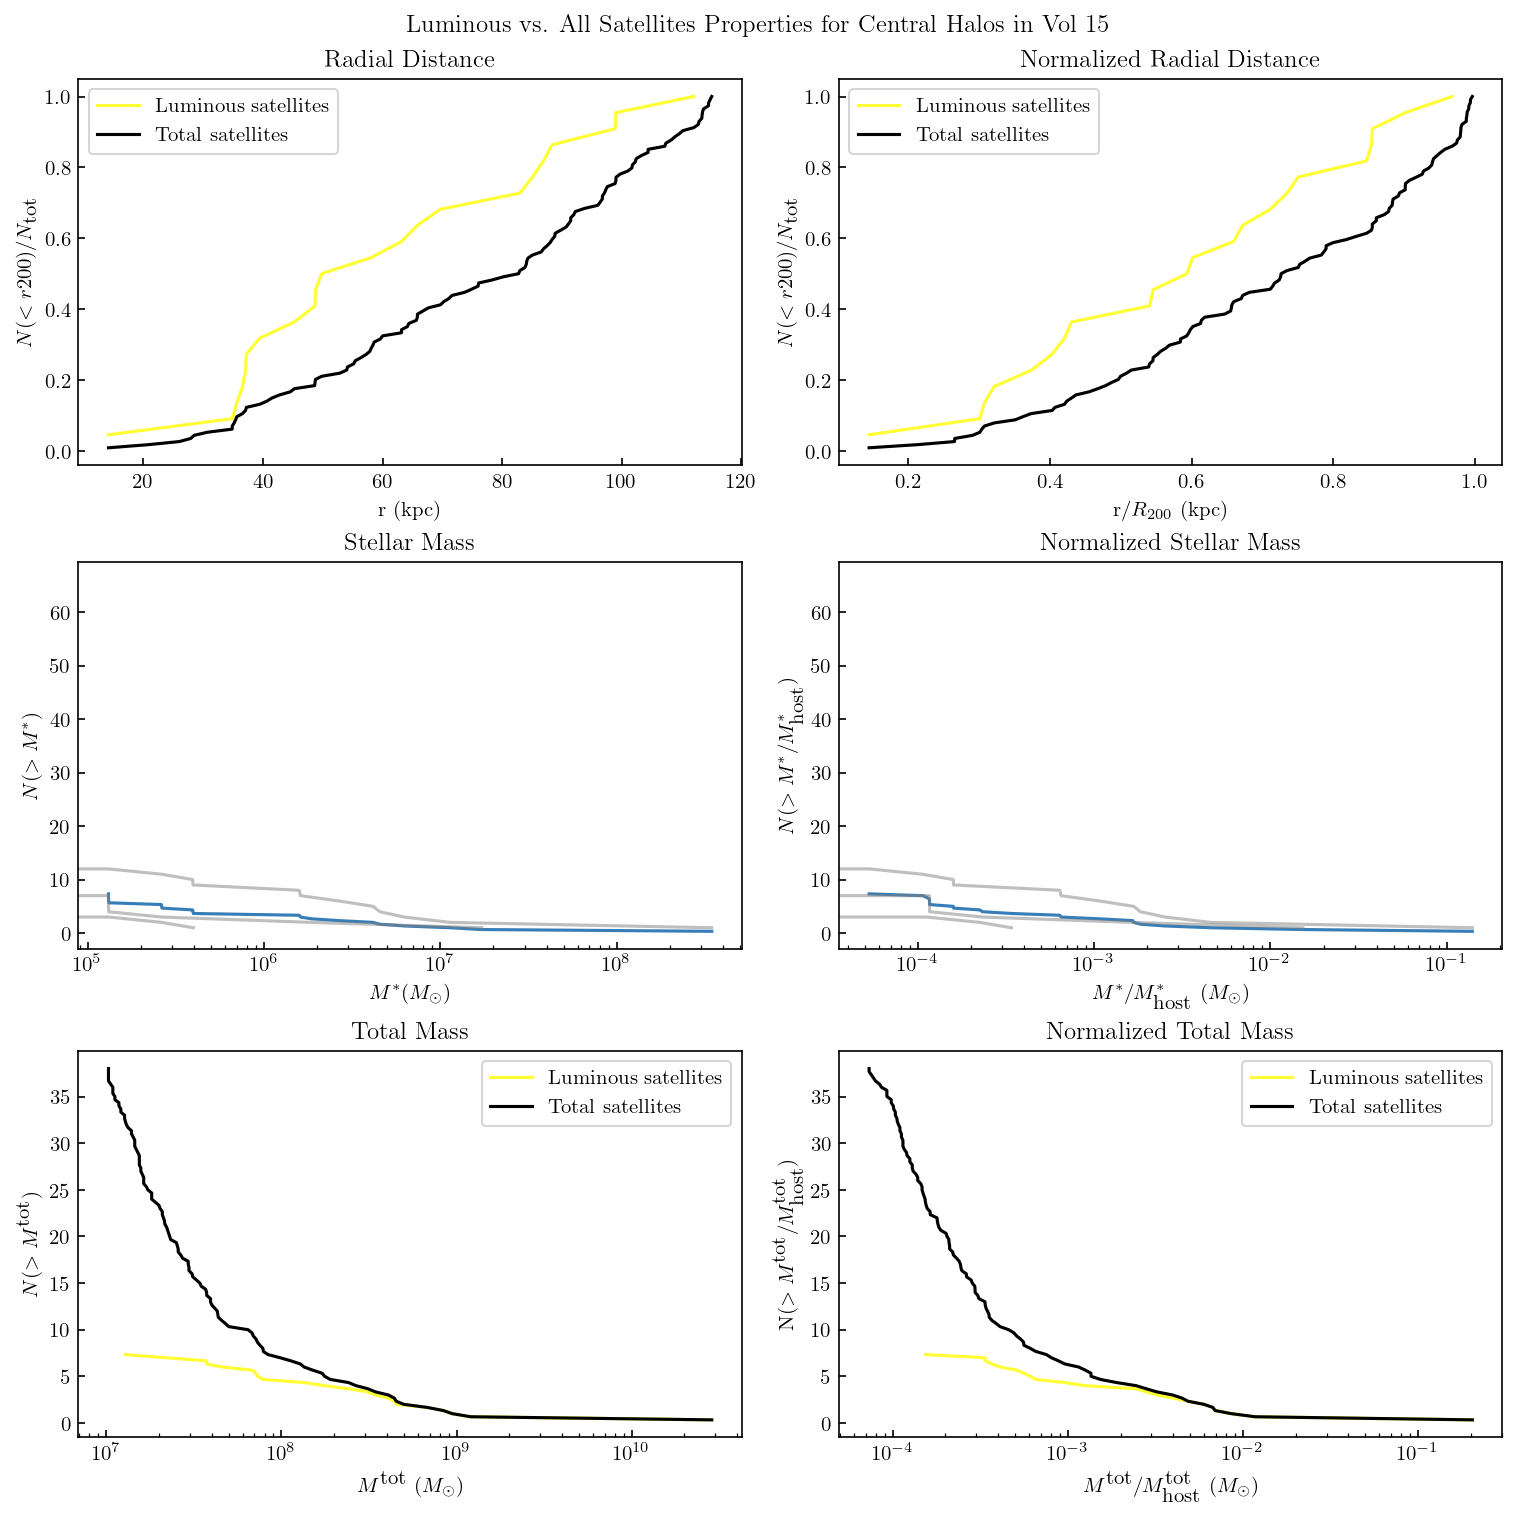

In [112]:
vol15_plotsim.lum_nonlum_number_plots()
#vol15_plotsim.smhm_centralhalos()

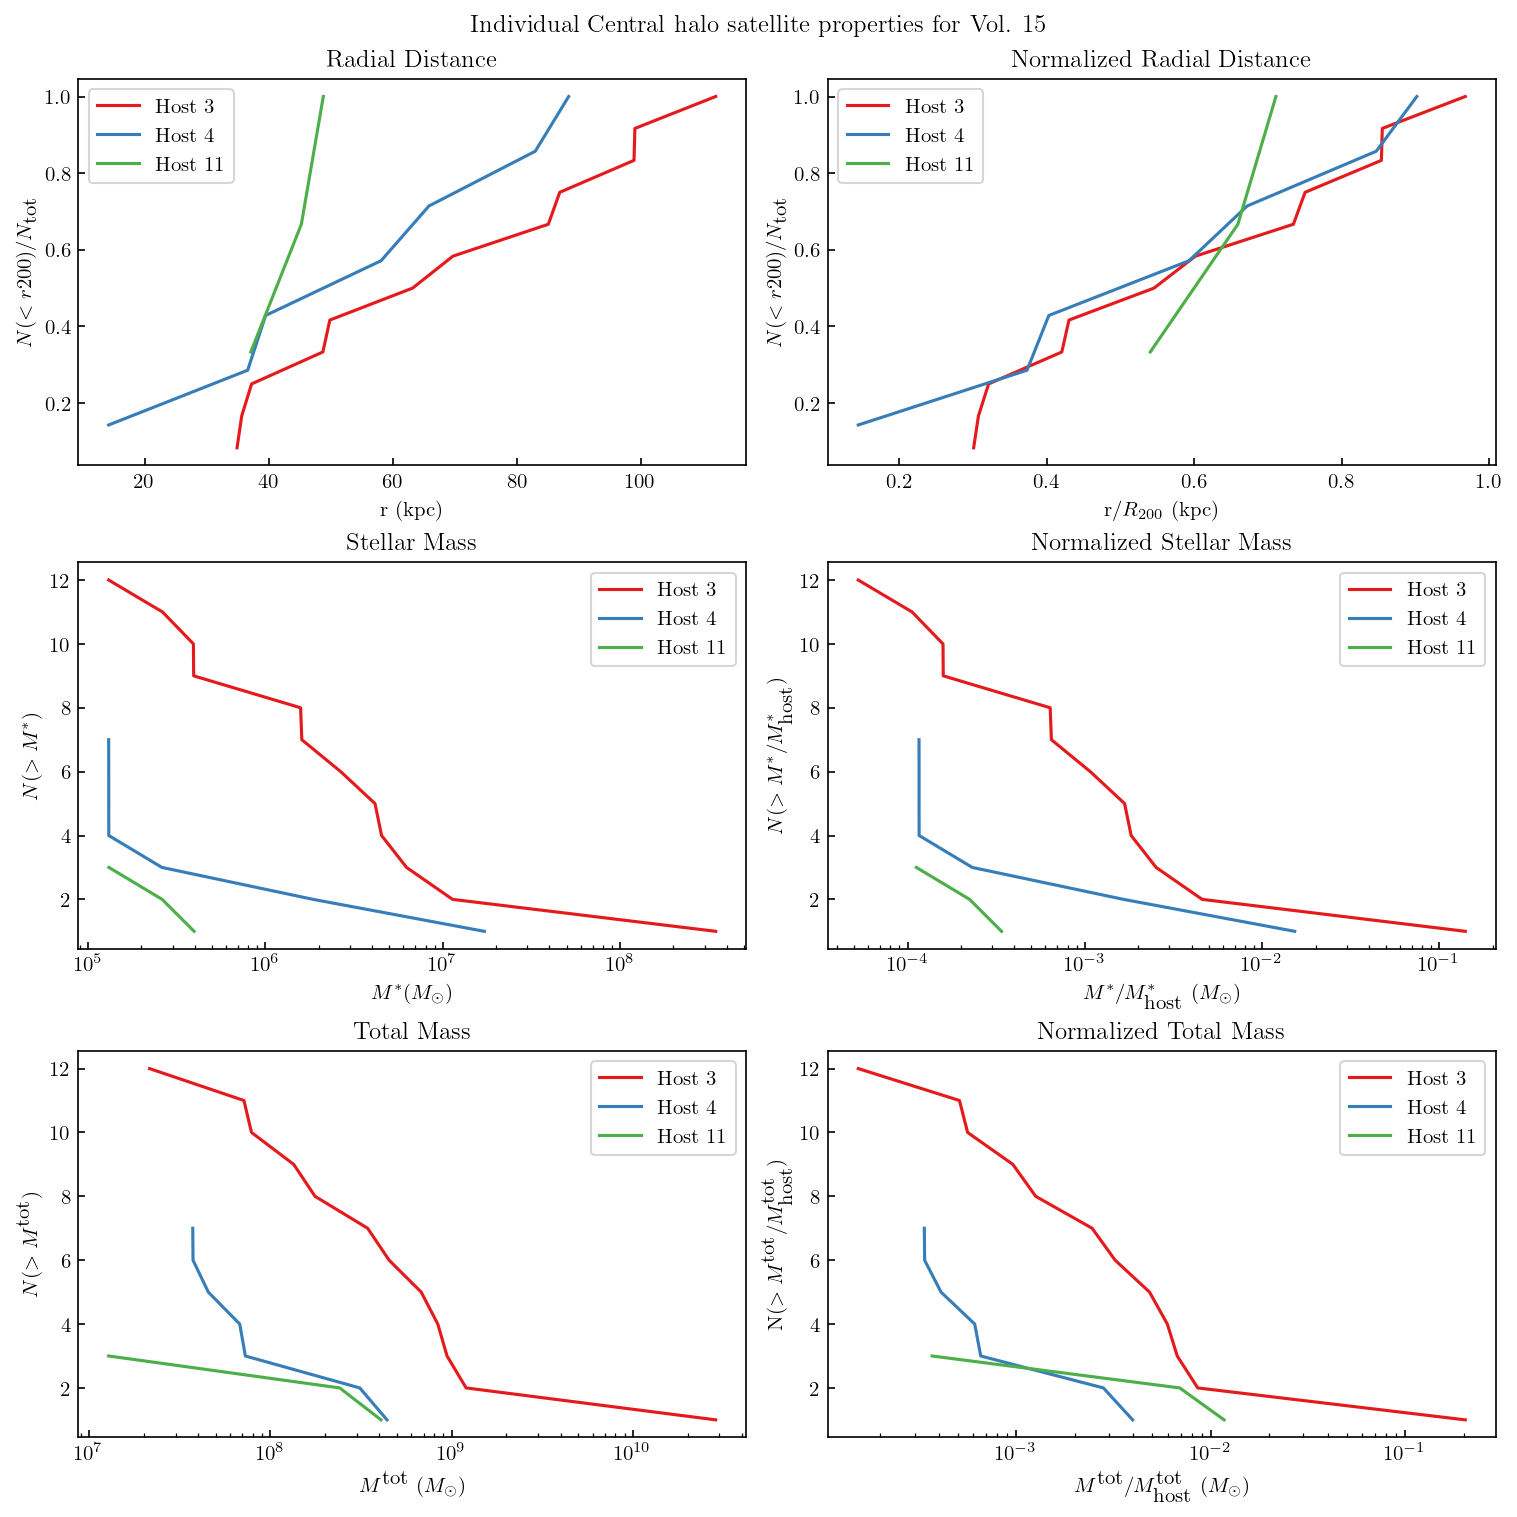

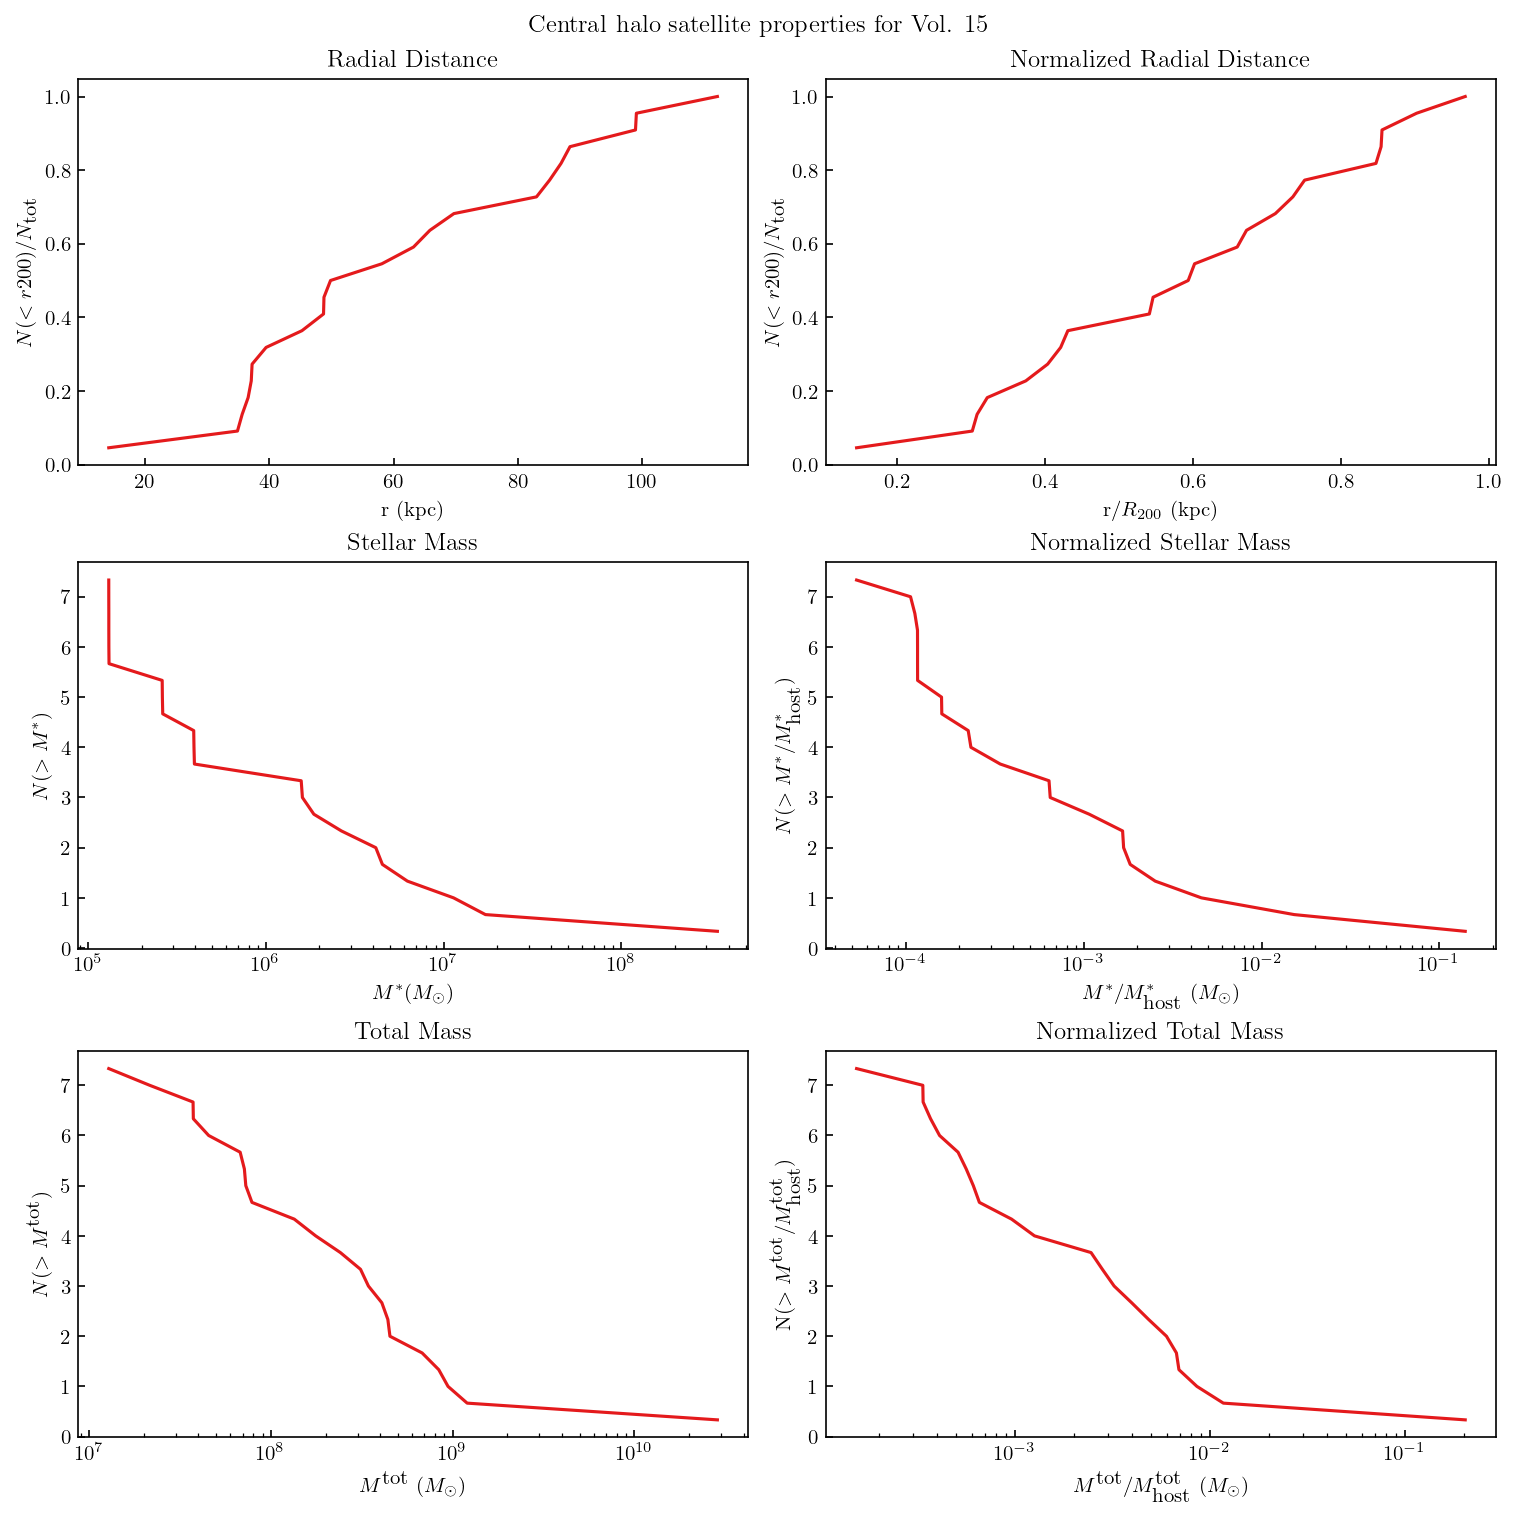

In [95]:
vol15_plotsim.number_plots(mstar_cut=True)
vol15_plotsim.avg_number_plots(mstar_cut=True)

/tmp/ipykernel_220619/790447973.py:293: RuntimeWarning: divide by zero encountered in log10
  axs[0].hist(np.log10(np.ma.array(self.main_df['Host Mtot'])))
/tmp/ipykernel_220619/790447973.py:294: RuntimeWarning: divide by zero encountered in log10
  axs[1].hist(np.log10(np.ma.array(self.main_df['Host M*'])))
/tmp/ipykernel_220619/790447973.py:281: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(self.mtotal[sorted_idx], self.mstar[sorted_idx], c=clrs[1], s = 7)


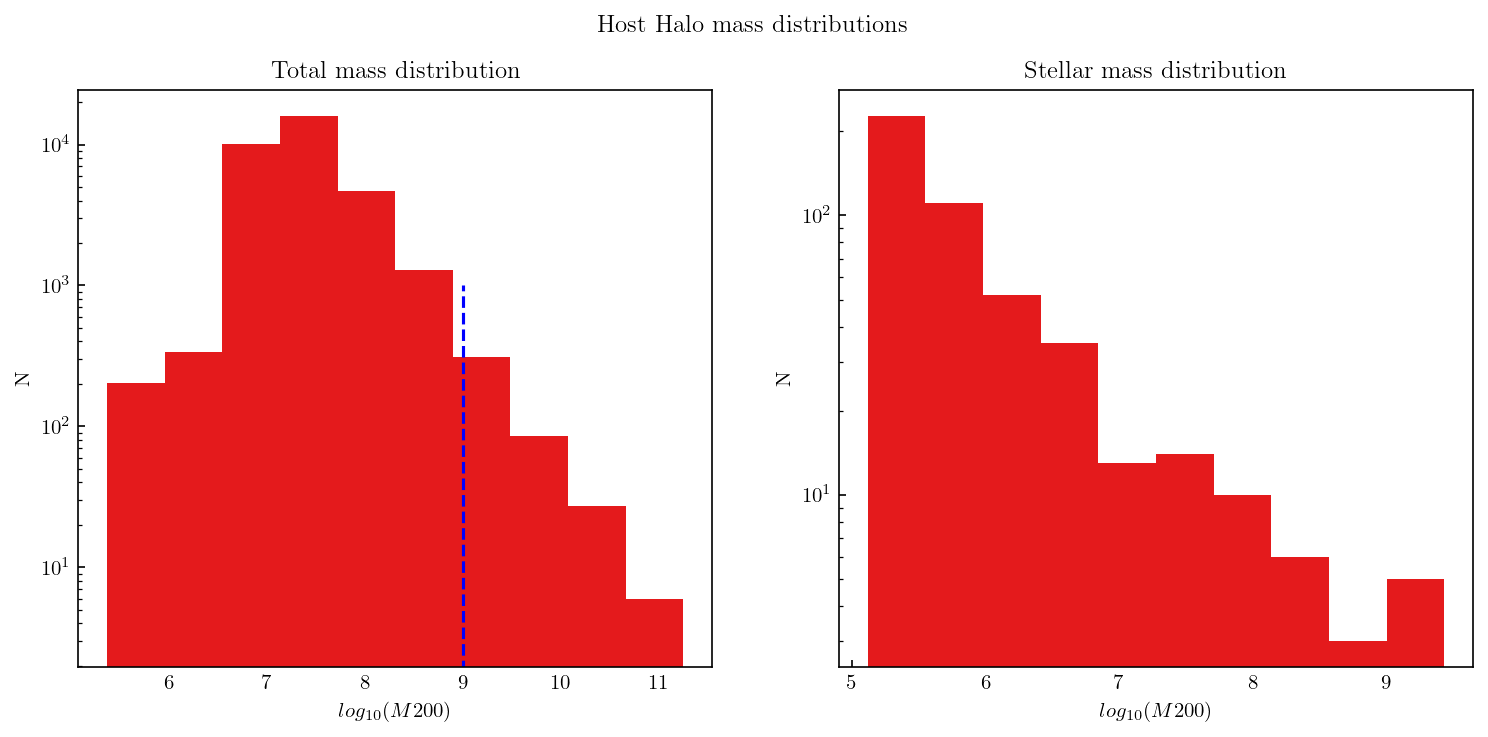

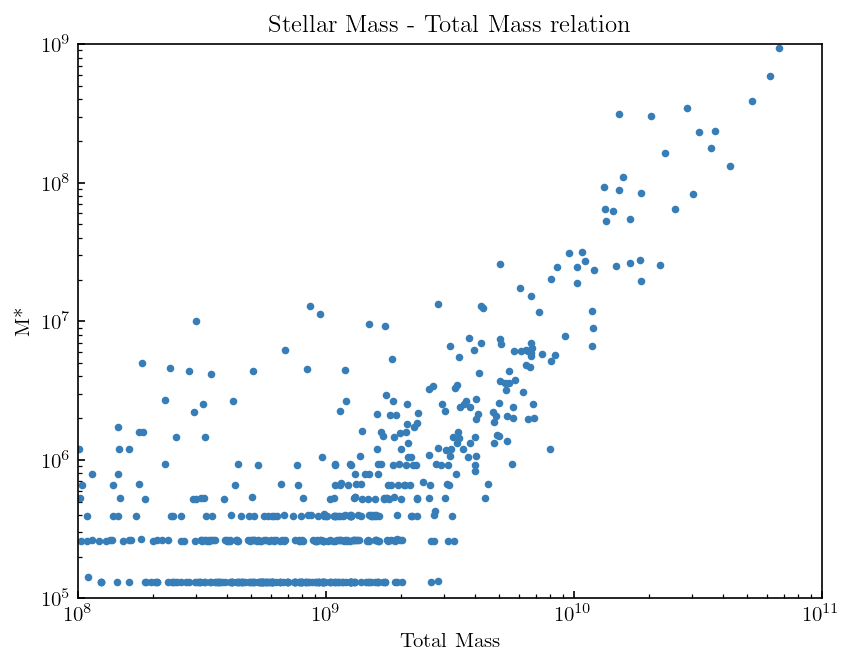

In [9]:
vol15_plotsim.plotFieldHaloMassDist()
vol15_plotsim.plotStellarMassHaloMass_all()

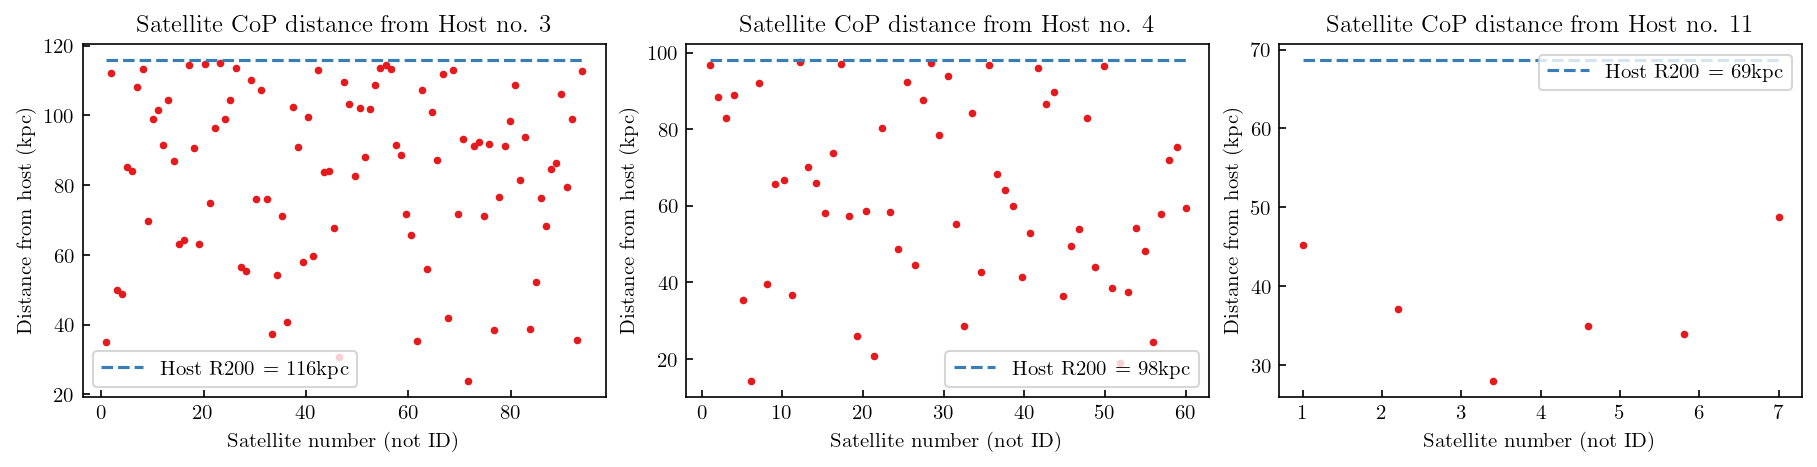

In [10]:
fig, ax = plt.subplots(1, len(vol15_df['Host ID']), figsize = (4*len(vol15_df['Host ID']), len(vol15_df['Host ID'])), dpi=150, constrained_layout=True)
ax_flat = ax.flatten()
central_centers = np.array(vol15_df['Host CoM'])
for i, host_center in enumerate(central_centers):
    sat_centers = np.array(vol15_df['Sat CoM'].iloc[i])
    distances = np.array([np.linalg.norm(sat-host_center) for sat in sat_centers])*1000 #in kpc
    x = np.linspace(1, len(distances)+1, len(distances)) 
    ax_flat[i].scatter(x, distances, s = 7)
    r200 = vol15_df['Host R200'].iloc[i]
    ax_flat[i].hlines(r200, min(x), max(x), clrs[1], '--', label = f'Host R200 = {r200:.0f}kpc')
    ax_flat[i].set_xlabel('Satellite number (not ID)')
    ax_flat[i].set_ylabel('Distance from host (kpc)')
    host_id = vol15_df['Host ID'].iloc[i]
    ax_flat[i].set_title(f'Satellite CoP distance from Host no. {host_id}')
    ax_flat[i].legend()
fig.show()

In [36]:
csv_file = 'data/volume_number_20.csv'
vol20_plotsim = SimToolsPlotting(csv_file)
vol20_df = vol20_plotsim.getCentralHalos()


/tmp/ipykernel_244178/4274811343.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.central_df[col].at[i] = np.array(self.central_df[col].loc[i])[distance_mask].tolist()


130497.40625
2.8653833842293822e-05


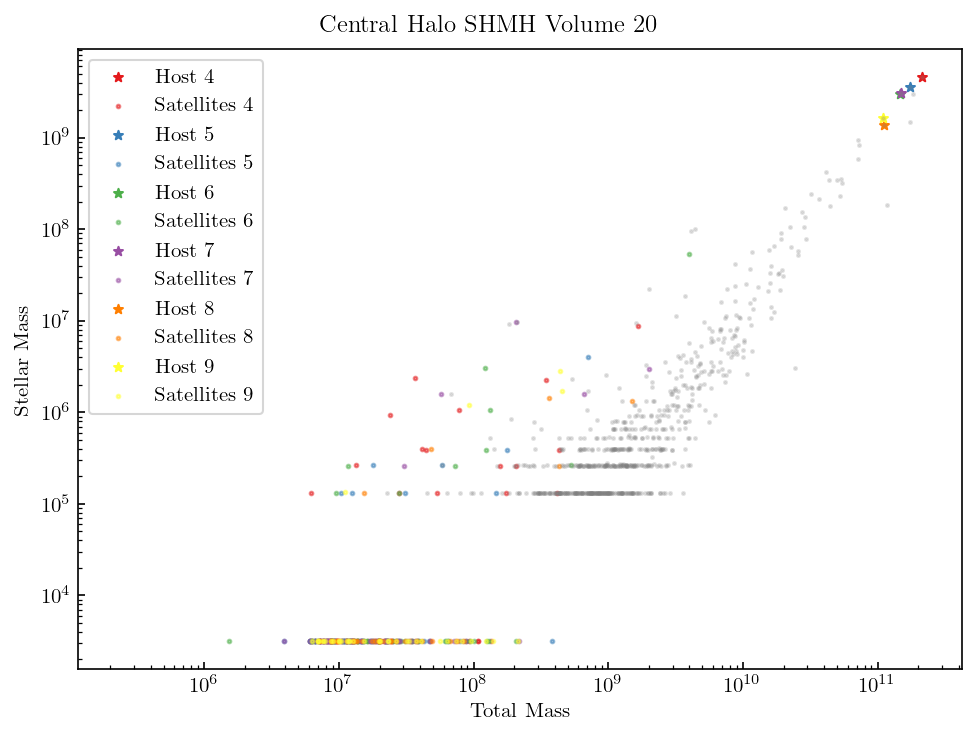

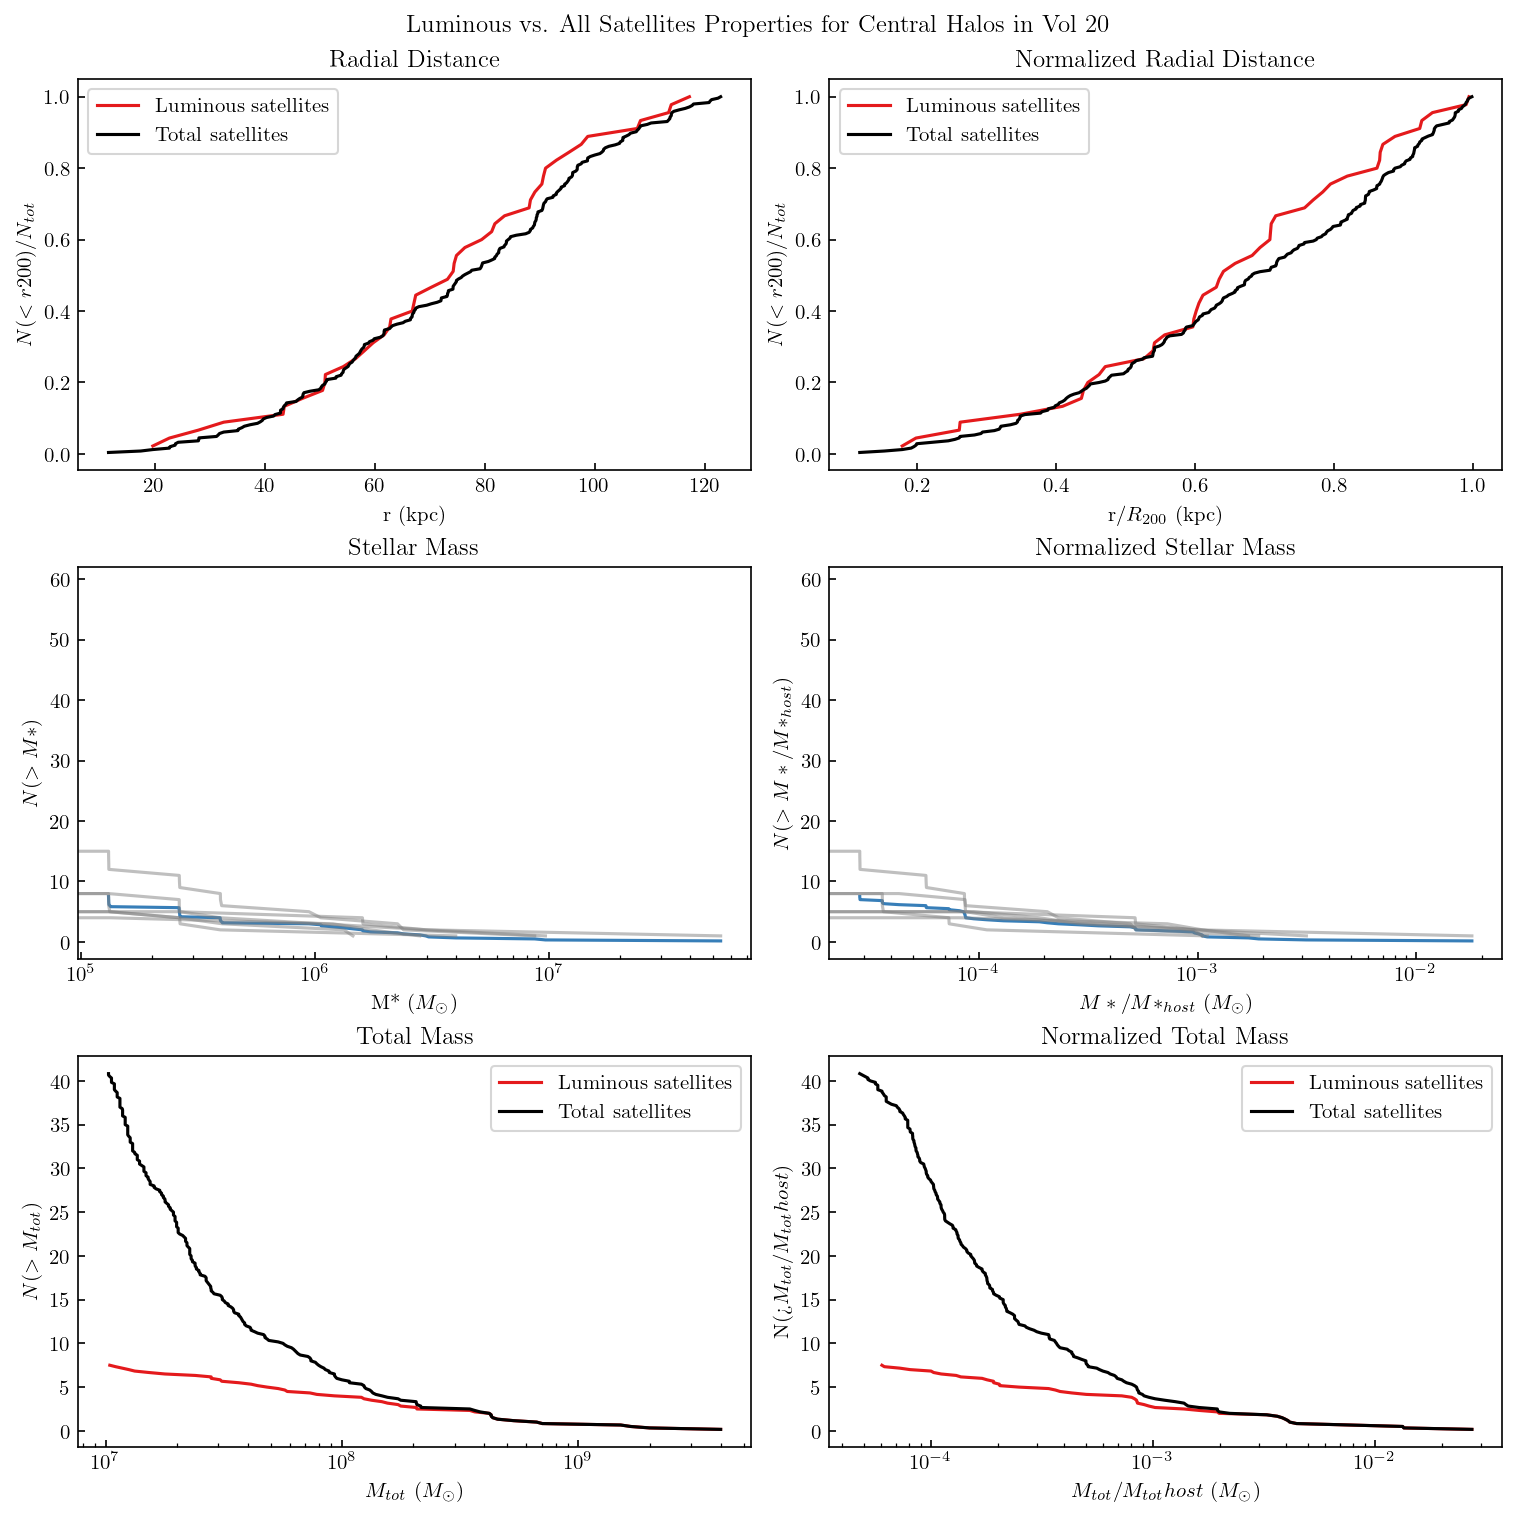

In [138]:
vol20_plotsim.smhm_centralhalos()
vol20_plotsim.lum_nonlum_number_plots()

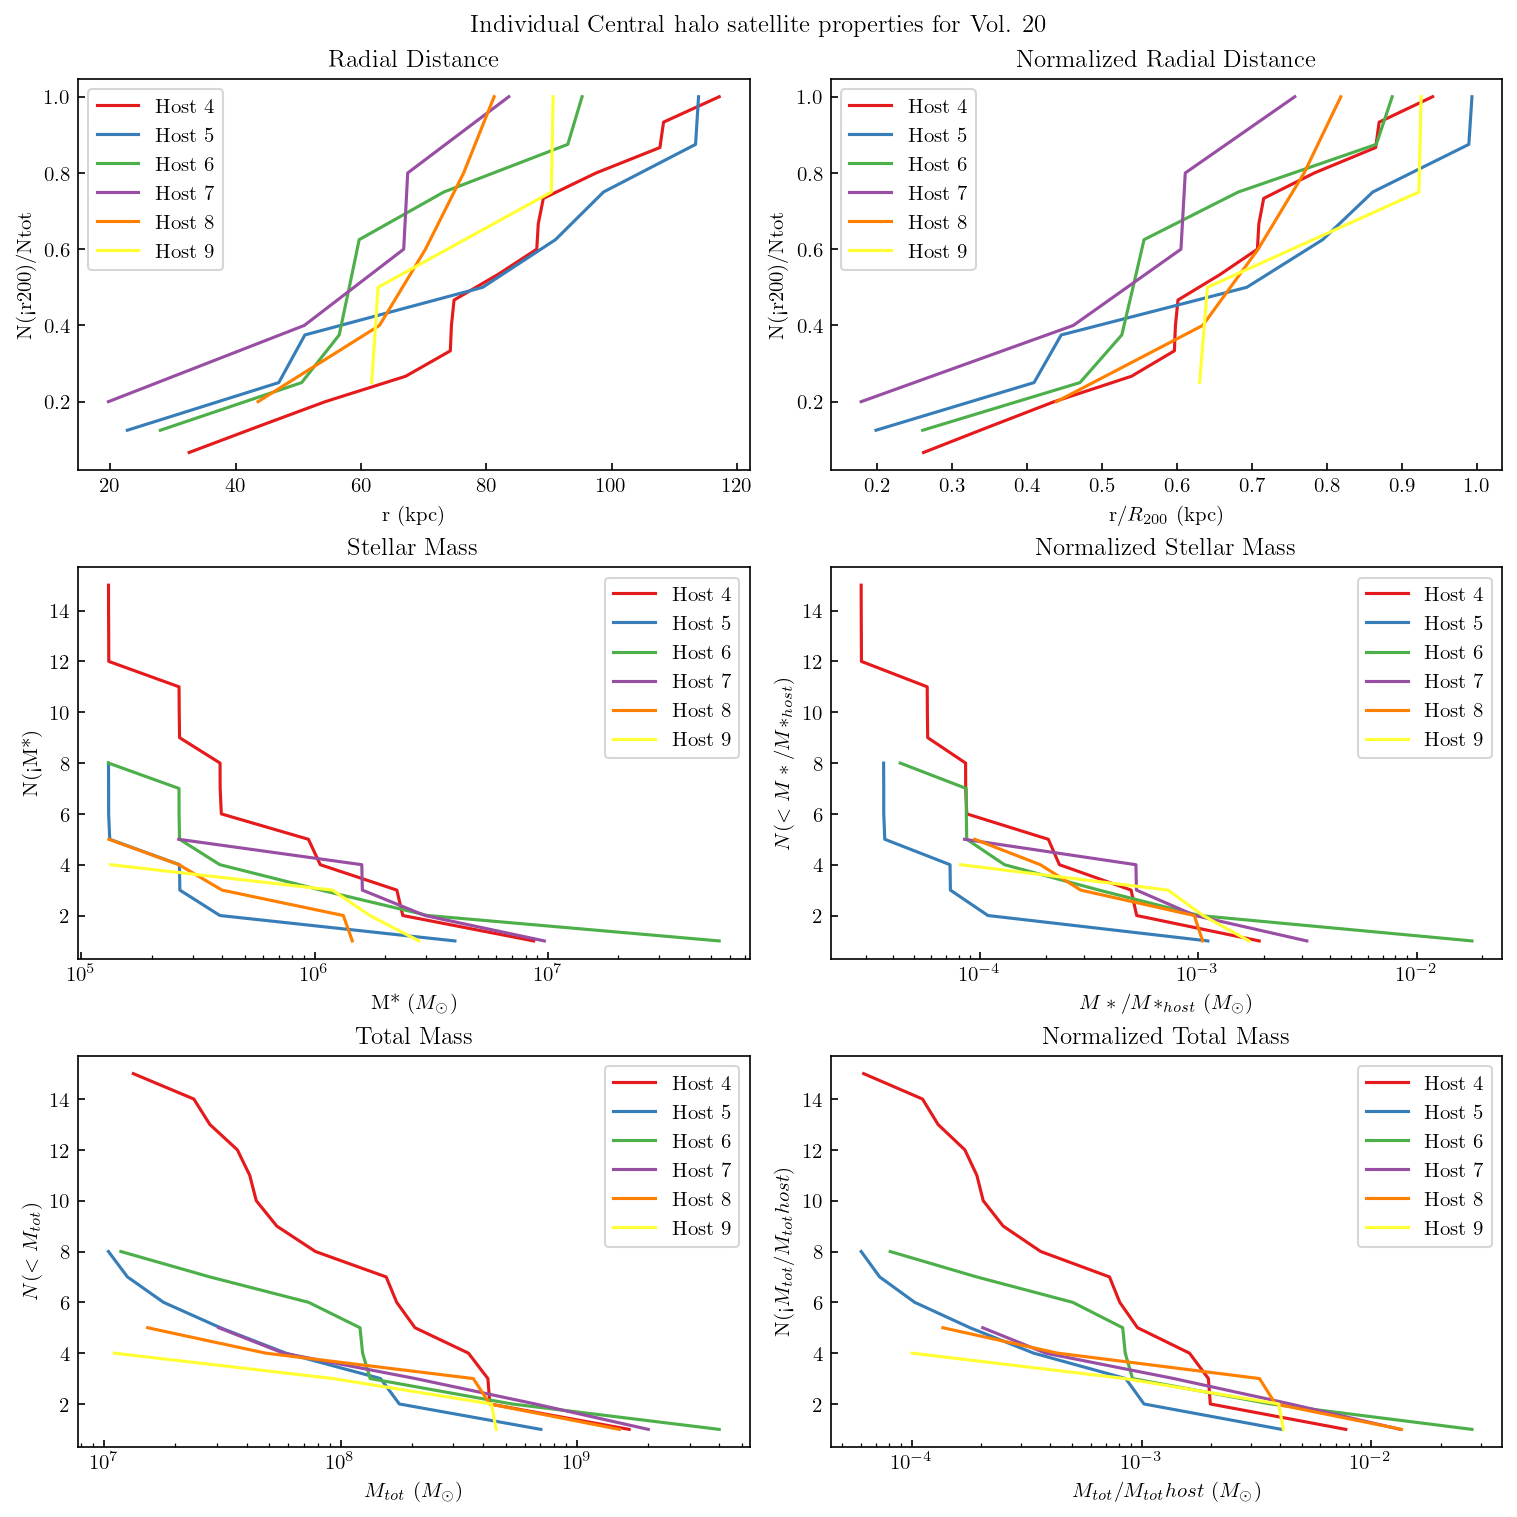

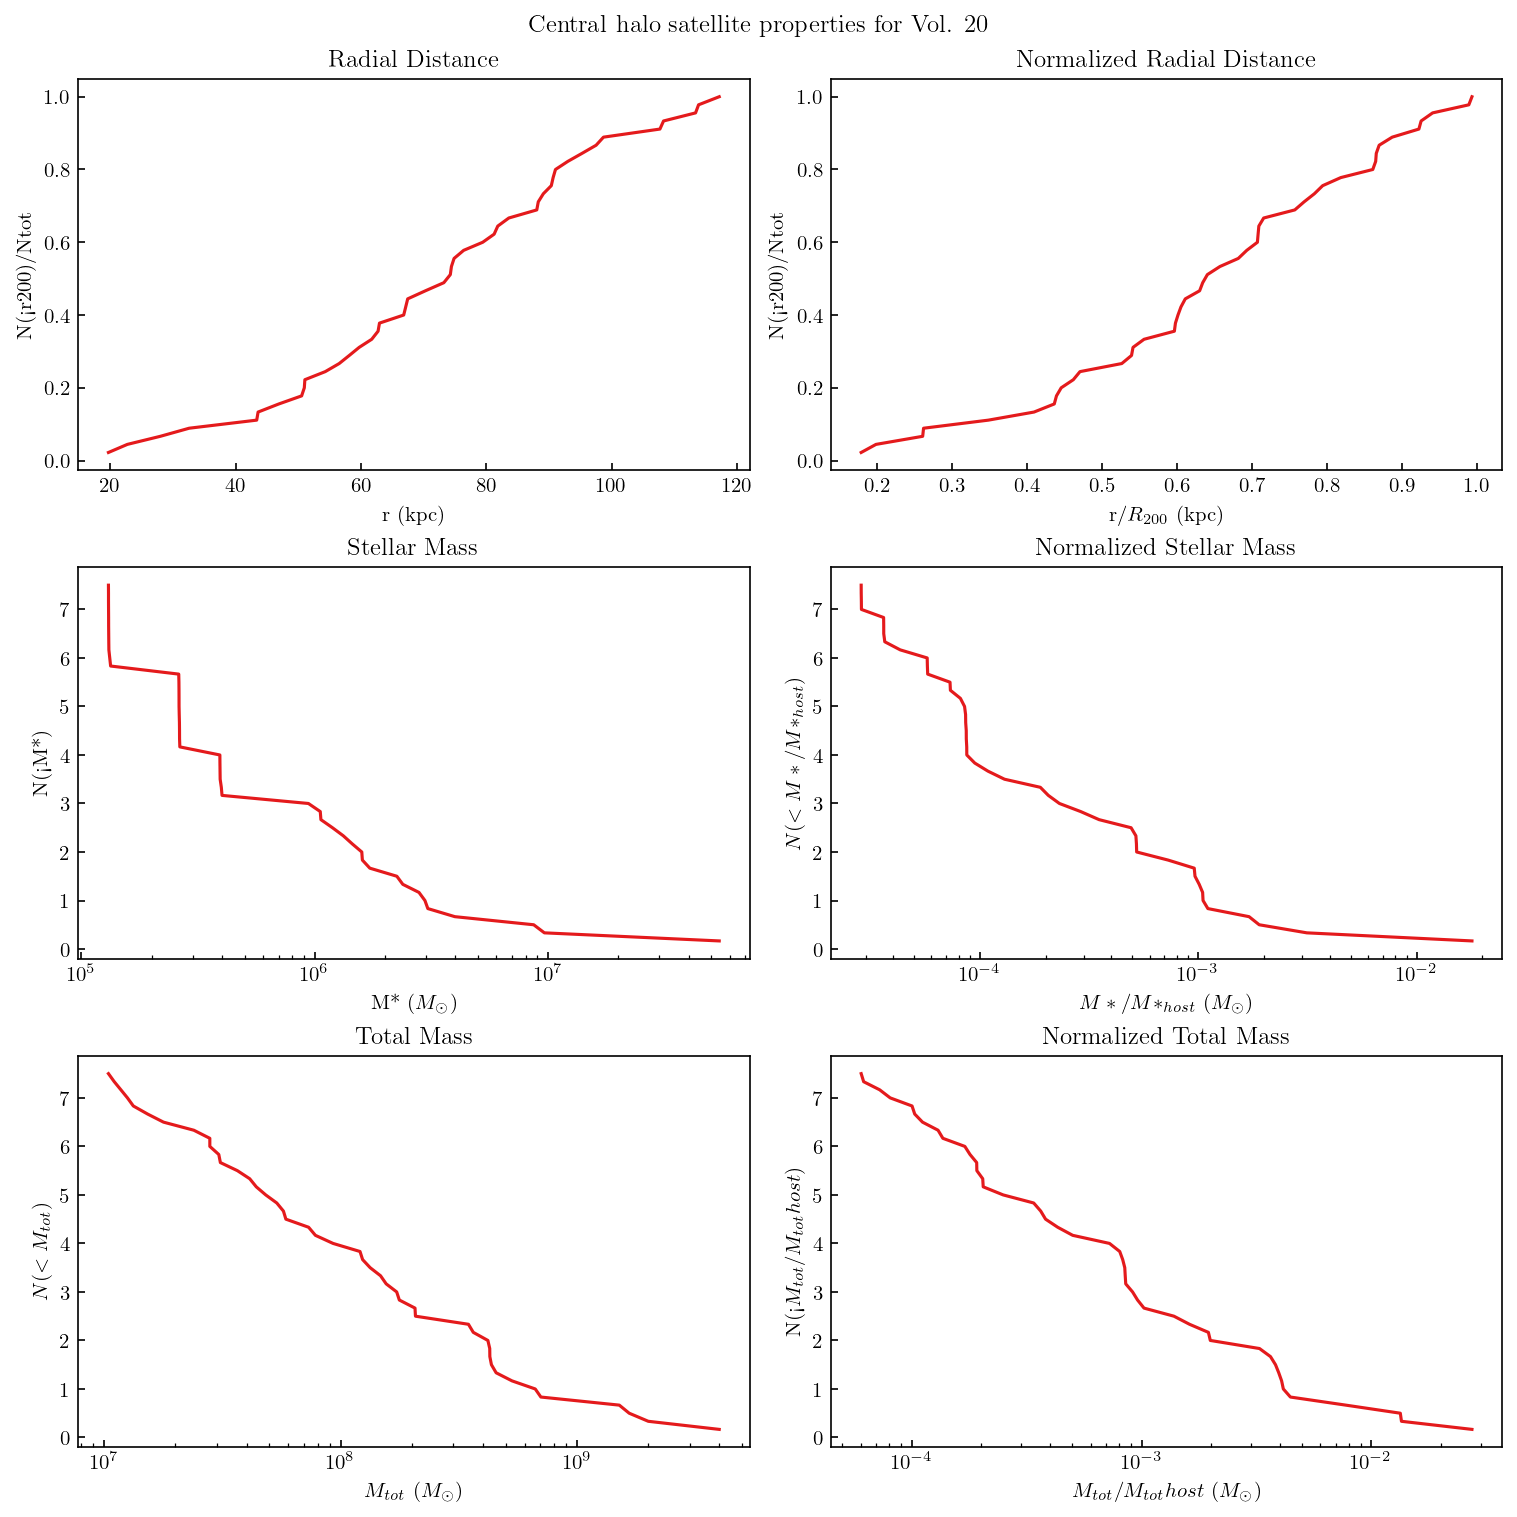

In [15]:
vol20_plotsim.number_plots(mstar_cut=True)
vol20_plotsim.avg_number_plots(mstar_cut=True)

In [ ]:
csv_file = 'data/volume_number_25.csv'
vol25_plotsim = SimToolsPlotting(csv_file)
vol25_df = vol25_plotsim.getCentralHalos()

In [ ]:
vol25_plotsim.number_plots(mstar_cut=True)
vol25_plotsim.avg_number_plots(mstar_cut=True)
vol25_plotsim.smhm_centralhalos()
vol25_plotsim.lum_nonlum_number_plots()

In [ ]:
csv_file = 'data/volume_number_10.csv'
vol10_plotsim = SimToolsPlotting(csv_file)
vol10_df = vol10_plotsim.getCentralHalos(dist_from_center=6)
vol10_plotsim.number_plots(mstar_cut=True)
vol10_plotsim.avg_number_plots(mstar_cut=True)
vol10_plotsim.smhm_centralhalos()
vol10_plotsim.lum_nonlum_number_plots()

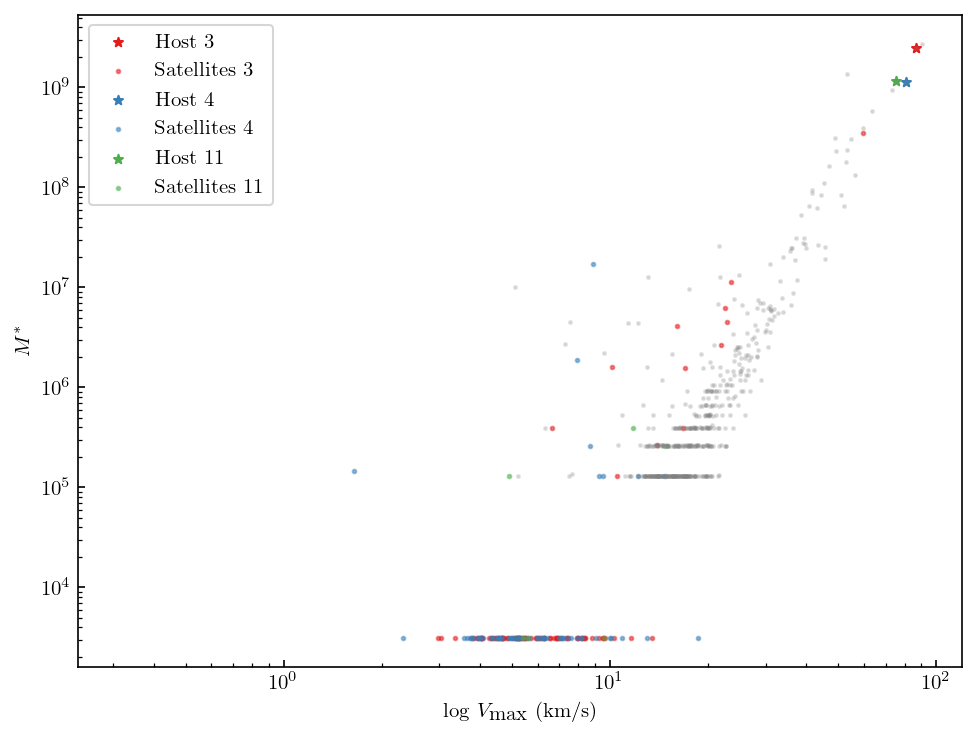

In [39]:
#make stellar mass hallo mass plots for each host and its respective satelites
fig, ax = plt.subplots(dpi=150, constrained_layout=True)
cmap = plt.get_cmap('Set1')
for i in range(len(vol15_df['Host i'])):
    host_id = vol15_df['Host ID'].iloc[i]
    ax.scatter(vol15_df['Host Vmax'].iloc[i], vol15_df['Host M*'].iloc[i], s=20, color = cmap(i), label=f'Host {host_id}', marker='*')
    sat_mstar_array = np.array(vol15_df['Sat M*'].iloc[i])
    # Replace 0 values with 10^4
    sat_mstar_array[sat_mstar_array == 0.0] = 10**3.5 #to distinguish between hosts
    ax.scatter(vol15_df['Sat Vmax'].iloc[i], sat_mstar_array, s=3, color = cmap(i), alpha = 0.5, label=f'Satellites {host_id}')
ax.scatter(vol15_plotsim.main_df['Host Vmax'], vol15_plotsim.main_df['Host M*'], c='Gray', s=2, alpha=0.2)

ax.set_xlabel(r'log $V_{\textrm{max}}$ (km/s)')
ax.set_ylabel(r'$M^*$')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
#fig.suptitle(f'Central Halo SHMH Volume {self.vol}')
fig.show()


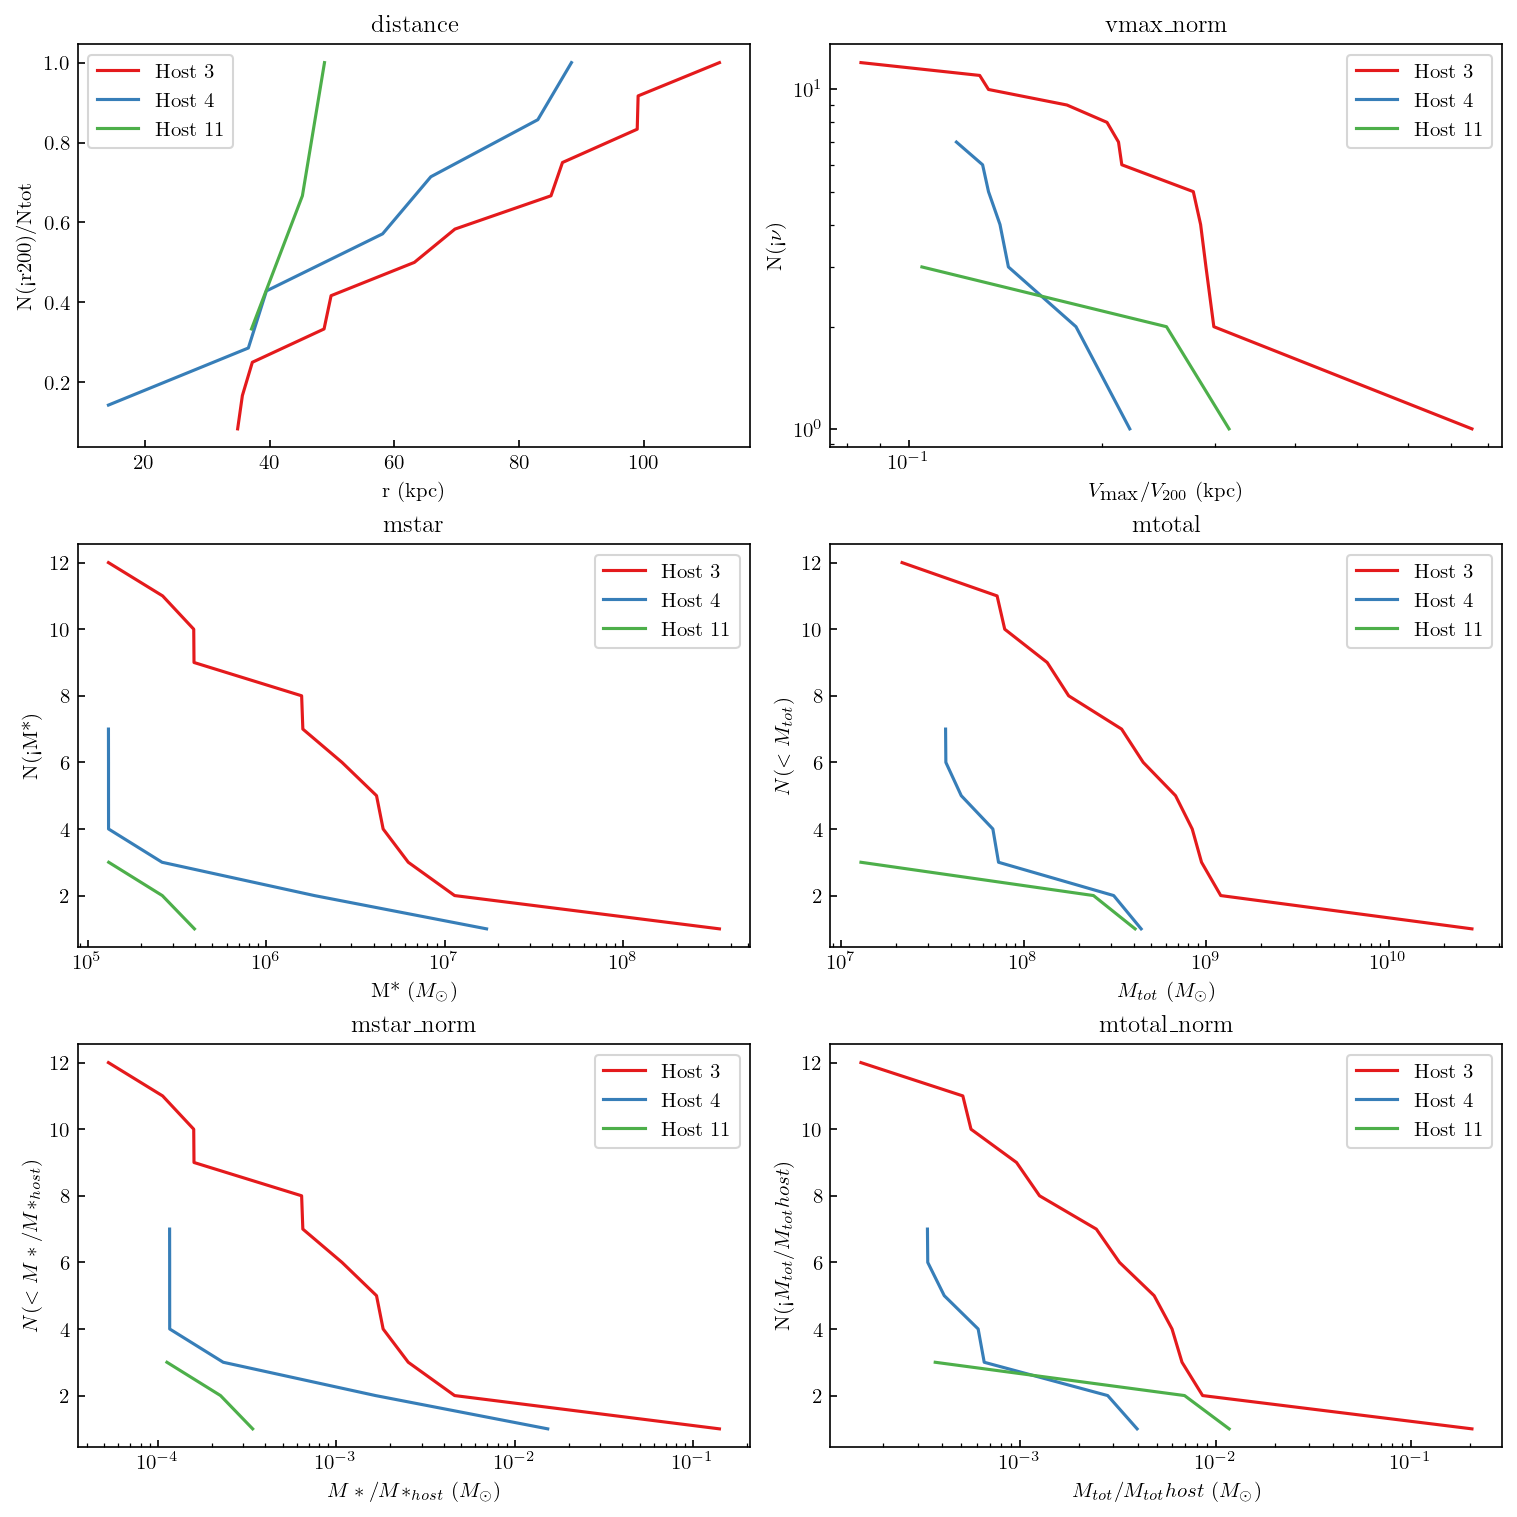

In [41]:
mstar_cut=True

fig, ax = plt.subplots(3, 2, figsize = (10, 10), dpi=150, constrained_layout=True)
ax_flat = ax.flatten()
central_df = vol15_df.copy(deep=True)

for i in vol15_df['Host i']:
    mtot_mask = np.array(vol15_df['Sat Mtot'].loc[i]) > 10**7
    mstar_mask = np.array(vol15_df['Sat M*'].loc[i]) > 1e5
    for col in vol15_plotsim.sat_cols:
        if mstar_cut:
            central_df[col].at[i] = np.array(vol15_df[col].loc[i])[mtot_mask & mstar_mask]
        else:
            central_df[col].at[i] = np.array(vol15_df[col].loc[i])[mtot_mask]

for i in central_df['Host i']:
    r200 = central_df['Host R200'].loc[i]
    v200 = central_df['Host R200'].loc[i]*0.681
    nu = central_df['Sat Vmax'].loc[i]
    host_center = np.array(central_df['Host CoM'].loc[i])
    satellite_centers = central_df['Sat CoM'].loc[i]
    distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers]) * 1000

    arrays = {
        'distance': distances,
        'vmax_norm': nu / v200,
        'mstar': central_df['Sat M*'].loc[i], 
        'mtotal': central_df['Sat Mtot'].loc[i], 
        'mstar_norm': central_df['Sat M*'].loc[i] / central_df.loc[i]['Host M*'], 
        'mtotal_norm': central_df['Sat Mtot'].loc[i] / central_df.loc[i]['Host Mtot']
    }
    
    # Loop over the first 6 keys in the arrays dictionary
    for j, key in enumerate(list(arrays.keys())):
        # Get the x values and sort them in reverse order
        x_values = sorted(arrays[key], reverse=True)

        # Determine y values
        if key == 'distance' or key == 'distance_norm':
            y_values = np.linspace(len(x_values), 1, len(x_values)) / len(x_values)
        else:
            ax_flat[j].set_xscale('log')
            y_values = np.arange(1, len(x_values) + 1)

        # Plot the values with a label for the host index
        host_id = vol15_df.loc[i]['Host ID']
        ax_flat[j].plot(x_values, y_values, '-', label=f'Host {host_id}')
        ax_flat[j].set_title(key)
        ax_flat[j].legend()

ax_flat[0].set_xlabel('r (kpc)')
ax_flat[0].set_ylabel('N(<r200)/Ntot')

ax_flat[1].set_xlabel(r'$V_{\textrm{max}}$/$V_{200}$ (kpc)')
ax_flat[1].set_ylabel(r'N(<$\nu$)')
ax_flat[1].set_yscale('log')
ax_flat[1].set_xscale('log')

ax_flat[2].set_xlabel(r'M* ($M_\odot$)')
ax_flat[2].set_ylabel('N(<M*)')
#ax_flat[2].set_yscale('log')

ax_flat[3].set_xlabel(r'$M_{tot}$ ($M_{\odot}$)')
ax_flat[3].set_ylabel('$N(<M_{tot})$')
#ax_flat[3].set_yscale('log')

ax_flat[4].set_xlabel(r'$M*/M*_{host}$ ($M_{\odot}$)')
ax_flat[4].set_ylabel('$N(<M*/M*_{host})$')
#ax_flat[4].set_yscale('log')

ax_flat[5].set_xlabel(r'$M_{tot}/M_{tot} host$ ($M_{\odot}$)')
ax_flat[5].set_ylabel(r'N(<$M_{tot}/M_{tot} host$)')
#ax_flat[5].set_yscale('log')

#fig.suptitle(f'Individual Central halo satellite properties {self.vol}')

plt.show()

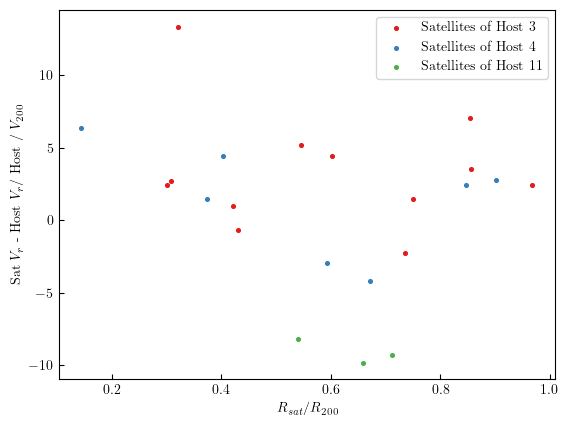

In [42]:
for i in central_df['Host i']:
    host_center = np.array(central_df['Host CoM'].loc[i])
    satellite_centers = central_df['Sat CoM'].loc[i]
    distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers])*1000 #kpc
    dist_vector = (np.array(satellite_centers) - host_center)
    dist_vector_norm = [r*1000/dist for r,dist in zip(dist_vector, distances)] #kpc for r*1000 ##fine
    relative_v = central_df['Sat CoMV'].loc[i]-central_df['Host CoMV'].loc[i]
    sat_Vr = [np.dot(v, d) for v,d in zip(dist_vector_norm,relative_v)]
    host_V200 = np.sqrt(central_df['Host R200'].loc[i]*0.681)
    plt.scatter(distances/central_df['Host R200'].loc[i], (sat_Vr)/host_V200, label=f'Satellites of Host {i+1}', s=7)
    #plt.scatter(distances/central_df['Host R200'].loc[i], (sat_Vr), label=f'Satellites of Host {i+1}', s=7)
    dist = np.linspace(0.1,1,100)
    G = 4.3e-6 #kpc
    esc_v = np.sqrt(2 * G * central_df['Host Mtot'].loc[i] / (dist * central_df['Host R200'].loc[i]))/host_V200
    #plt.plot(dist, esc_v, 'Black')
    #plt.plot(dist, -esc_v, 'Black')
    #plt.ylim(-5,5)

plt.xlabel(r'$R_{sat}/R_{200}$')
plt.ylabel(r'Sat $V_r$ - Host $V_r$/ Host / $V_{200}$')
plt.legend()
plt.show()

#all sat v luminous sat for all halos in all vols

In [43]:
combined_central_df = pd.read_csv('combined_central_df.csv', converters={'Host CoM':pd.eval, 'Host CoMV':pd.eval, 'Sat ID':pd.eval, 'Sat i':pd.eval, 'Sat Mtot':pd.eval, 'Sat M*':pd.eval, 'Sat CoM': pd.eval, 'Sat Mhyd': pd.eval,
            'Sat Mgas':pd.eval,
            'Sat HalfM* radius':pd.eval,
            'Sat M* Metal':pd.eval,
            'Sat M* Iron':pd.eval,
            'Sat vel': pd.eval,
            'Sat Vmax': pd.eval,
            'Sat CoMV': pd.eval})

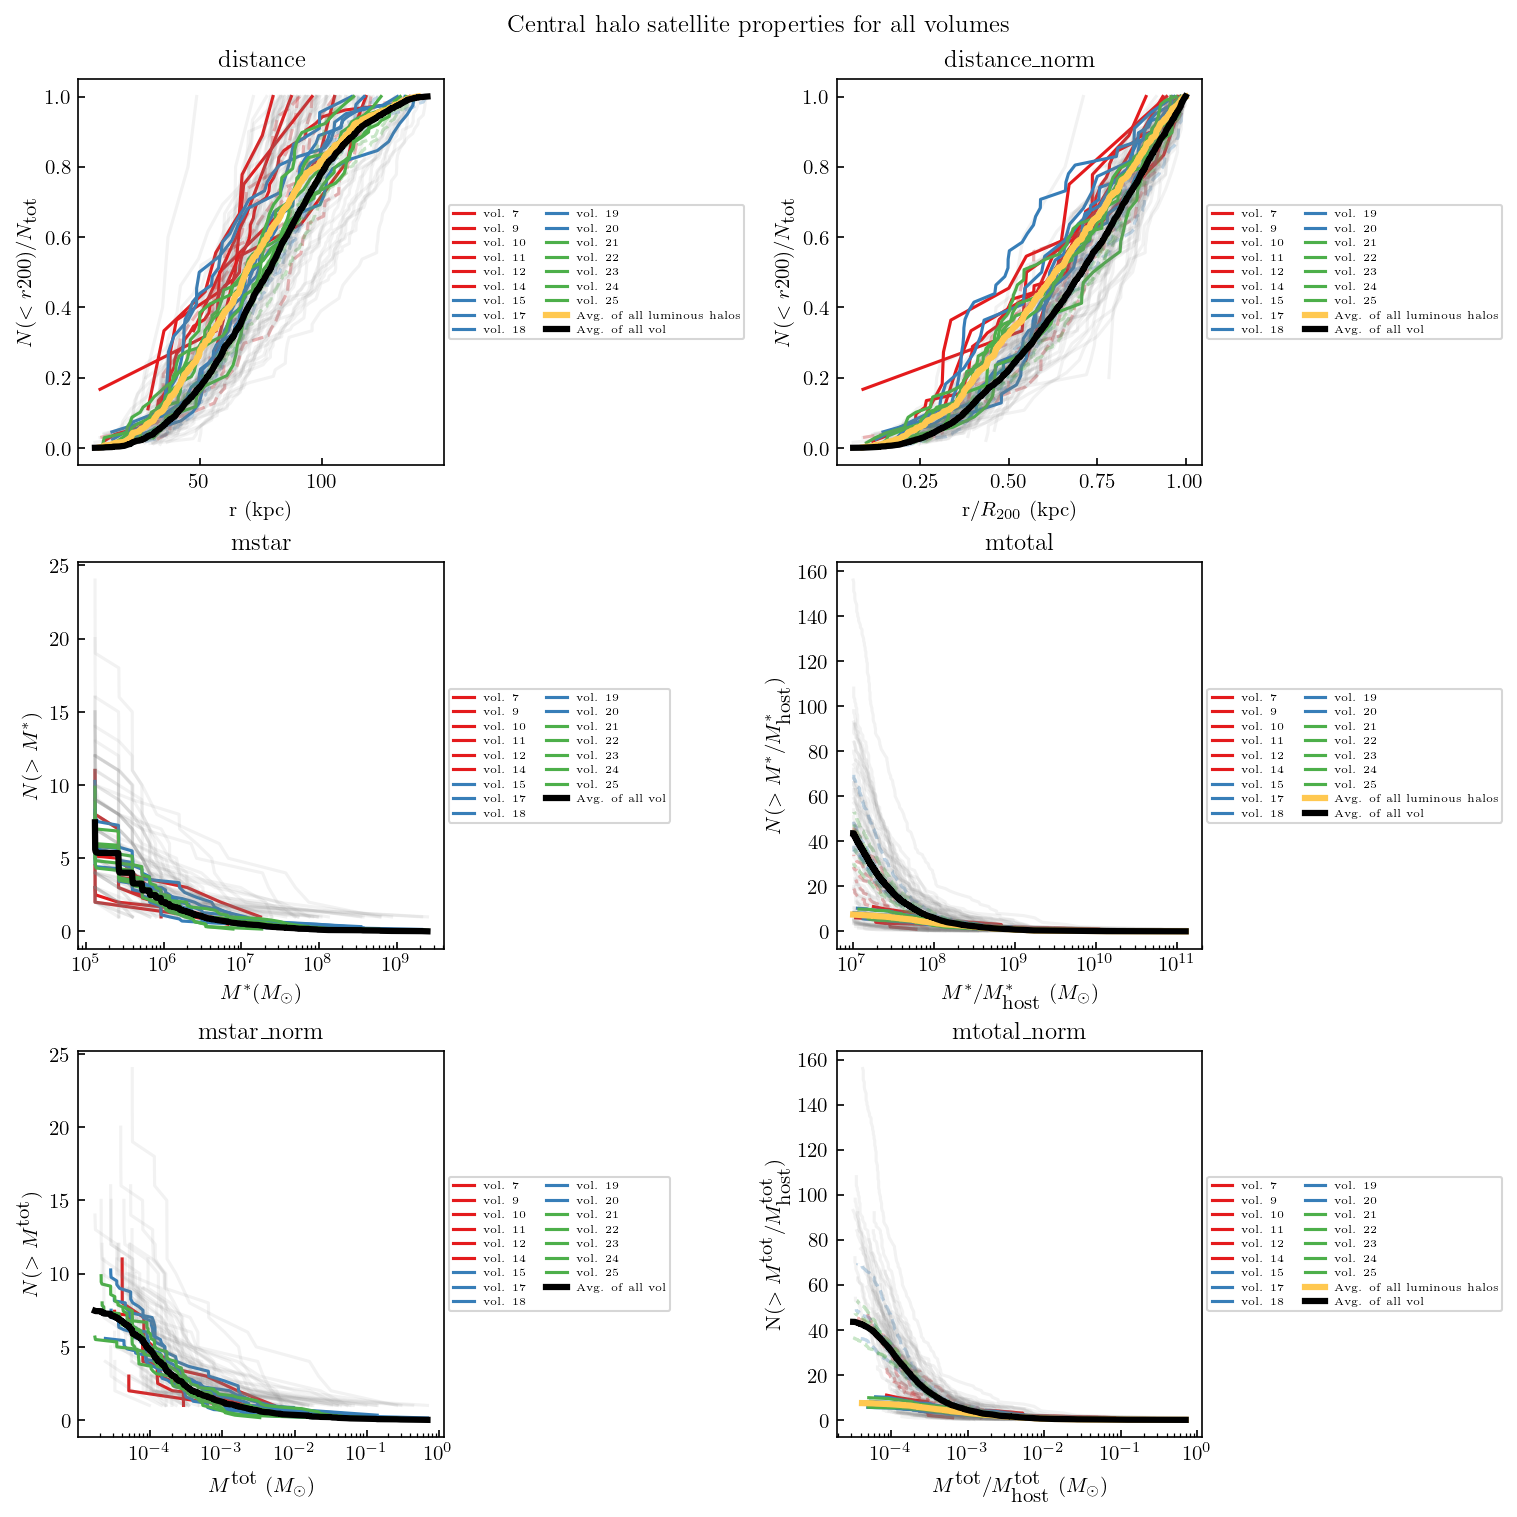

In [139]:
mstar_cut = False
mtot_cut = True
fig, ax = plt.subplots(3, 2, figsize=(10, 10), dpi=150, constrained_layout=True)
ax_flat = ax.flatten()

# Initialize dictionary to store all values
all_array = {
    'distance': [],
    'distance_norm': [],
    'mstar': [],
    'mtotal': [],
    'mstar_norm': [],
    'mtotal_norm': []
}

volumes = combined_central_df['Volume'].unique()
num_haloes = np.array(combined_central_df.groupby('Volume').count()['Host i'])
vol_cut_start = 0

for vol_idx, vol in enumerate(volumes[vol_cut_start:]):
    arrays = {
        'distance': [],
        'distance_norm': [],
        'mstar': [],
        'mtotal': [],
        'mstar_norm': [],
        'mtotal_norm': []
    }

    central_df = combined_central_df[combined_central_df['Volume'] == vol].copy(deep=True)

    mtot_mask = [np.array(central_df['Sat Mtot'].loc[i]) > 10**7 for i in central_df.index]
    for col in vol15_plotsim.sat_cols:
        for i in range(len(mtot_mask)):
            central_df.at[central_df.index[i], col] = np.array(central_df[col].iloc[i])[mtot_mask[i]]

    for i in central_df.index:
        r200 = central_df['Host R200'].loc[i]
        host_center = np.array(central_df['Host CoM'].loc[i])
        satellite_centers = central_df['Sat CoM'].loc[i]
        distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers]) * 1000

        sat_mstar = central_df['Sat M*'].loc[i]
        sat_mtot = central_df['Sat Mtot'].loc[i]

        arrays['distance'].append(distances)
        arrays['distance_norm'].append(distances / r200)
        arrays['mstar'].append(sat_mstar)
        arrays['mtotal'].append(sat_mtot)
        arrays['mstar_norm'].append(sat_mstar / central_df['Host M*'].loc[i])
        arrays['mtotal_norm'].append(sat_mtot / central_df['Host Mtot'].loc[i])

    non_zero_mask = np.concatenate([np.array(array) != 0 for array in arrays['mstar']])

    for j, key in enumerate(arrays.keys()):
        if key in ['distance', 'distance_norm']:
            concatenated_array = np.concatenate(arrays[key])

            nonzero_x_values = sorted(concatenated_array[non_zero_mask], reverse=True)
            total_x_values = sorted(concatenated_array, reverse=True)

            nonzero_y_values = np.linspace(len(nonzero_x_values), 1, len(nonzero_x_values)) / len(nonzero_x_values)
            total_y_values = np.linspace(len(total_x_values), 1, len(total_x_values)) / len(total_x_values)

            ax_flat[j].plot(nonzero_x_values, nonzero_y_values, c=clrs[int((vol_idx-1) / 5)], label=f'vol. {vol}')
            ax_flat[j].plot(total_x_values, total_y_values, '--', c=clrs[int((vol_idx-1) / 5)], alpha=0.3)
            ax_flat[j].set_title(key)
            for array in arrays[key]:
                try:
                    x_values = sorted(array, reverse=True)
                    y_values = np.linspace(len(x_values), 1, len(x_values))/len(x_values)
                except TypeError:
                    x_values = []
                    y_values = []
                ax_flat[j].plot(x_values, y_values, alpha=0.1, c='gray')

        elif key in ['mtotal', 'mtotal_norm']:
            concatenated_array = np.concatenate(arrays[key])

            nonzero_x_values = sorted(concatenated_array[non_zero_mask], reverse=True)
            total_x_values = sorted(concatenated_array, reverse=True)

            nonzero_y_values = np.arange(1, len(nonzero_x_values) + 1) / len(central_df)
            total_y_values = np.arange(1, len(total_x_values) + 1) / len(central_df)

            ax_flat[j].plot(nonzero_x_values, nonzero_y_values, c=clrs[int((vol_idx-1) / 5)], label=f'vol. {vol}')
            ax_flat[j].plot(total_x_values, total_y_values, '--', c=clrs[int((vol_idx-1) / 5)], alpha=0.3)
            ax_flat[j].set_title(key)
            
            for i, array in enumerate(arrays[key]):
                try:
                    x_values = sorted(array, reverse=True)
                    y_values = np.arange(1, len(x_values) + 1)/num_haloes[i]
                except TypeError:
                    x_values = []
                    y_values = []                
                ax_flat[j].plot(x_values, y_values, alpha=0.1, c='gray')

        else:
            mstar_cut_mask = np.concatenate([np.array(array) > 1e5 for array in arrays['mstar']])
            mstar_concatenated = np.concatenate(arrays[key])[mstar_cut_mask]
            x_values_conc = sorted(mstar_concatenated, reverse=True)
            ax_flat[j].set_xscale('log')
            y_values_conc = np.arange(1, len(x_values_conc) + 1) / len(central_df)
            ax_flat[j].plot(x_values_conc, y_values_conc, c=clrs[int((vol_idx-1) / 5)], label=f'vol. {vol}')
            ax_flat[j].set_title(key)
            for i, array in enumerate(arrays[key]):
                x_values = sorted(array[arrays['mstar'][i]>1e5], reverse=True)
                y_values = np.arange(1, len(x_values) + 1)
                ax_flat[j].plot(x_values, y_values, alpha=0.1, c='gray')
        all_array[key].append(arrays[key])

for k, key in enumerate(all_array.keys()):
    non_zero_mask = np.concatenate([item for sublist in all_array['mstar'] for item in sublist]) !=0
    if key in ['distance', 'distance_norm']:
        combined_values = np.concatenate([item for sublist in all_array[key] for item in sublist])
        x_values = sorted(combined_values, reverse=True)
        y_values = np.linspace(len(x_values), 1, len(x_values)) / len(x_values)
        luminous_x_values = sorted(combined_values[non_zero_mask], reverse=True)
        luminous_y_values = np.linspace(len(luminous_x_values), 1, len(luminous_x_values)) / len(luminous_x_values)
        ax_flat[k].plot(luminous_x_values, luminous_y_values, lw=3, c=clrs[5], label='Avg. of all luminous halos')
        ax_flat[k].plot(x_values, y_values, lw=3, c='black', label='Avg. of all vol')
    elif key in ['mtotal', 'mtotal_norm']:
        combined_values = np.concatenate([item for sublist in all_array[key] for item in sublist])
        x_values = sorted(combined_values, reverse=True)
        y_values = np.arange(1, len(x_values) + 1) / np.sum(num_haloes[vol_cut_start:])
        luminous_x_values = sorted(combined_values[non_zero_mask])
        luminous_y_values = np.linspace(len(luminous_x_values), 1, len(luminous_x_values)) / np.sum(num_haloes[vol_cut_start:])
        ax_flat[k].plot(luminous_x_values, luminous_y_values, lw=3, c=clrs[5], label='Avg. of all luminous halos')
        ax_flat[k].plot(x_values, y_values, lw=3, c='black', label='Avg. of all vol')
    else:
        combined_values = np.concatenate([item for sublist in all_array[key] for item in sublist])
        mstar_cut_mask = np.concatenate([item for sublist in all_array['mstar'] for item in sublist]) > 1e5
        combined_values = combined_values[mstar_cut_mask]
        x_values = sorted(combined_values, reverse=True)
        y_values = np.arange(1, len(x_values) + 1) / np.sum(num_haloes[vol_cut_start:])
        ax_flat[k].plot(x_values, y_values, lw=3, c='black', label='Avg. of all vol')
    
    ax_flat[k].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fontsize=5)

ax_flat[0].set_xlabel('r (kpc)')
ax_flat[0].set_ylabel(r'$N(<r200)/N_{\textrm{tot}}$')

ax_flat[1].set_xlabel(r'r/$R_{200}$ (kpc)')
ax_flat[1].set_ylabel(r'$N(<r200)/N_{\textrm{tot}}$')

ax_flat[2].set_xlabel(r'$M^{*} (M_\odot$)')
ax_flat[2].set_ylabel(r'$N(>M^{*})$')
#ax_flat[2].set_yscale('log')

ax_flat[3].set_xlabel(r'$M^{*}/M^{*}_{\textrm{host}}$ ($M_{\odot}$)')
ax_flat[3].set_ylabel(r'$N(>M^{*}/M^{*}_{\textrm{host}})$')
ax_flat[3].set_xscale('log')

ax_flat[4].set_xlabel(r'$M^{\textrm{tot}}$ ($M_{\odot}$)')
ax_flat[4].set_ylabel(r'$N(>M^{\textrm{tot}})$')
#ax_flat[4].set_xscale('log')

ax_flat[5].set_xlabel(r'$M^\textrm{tot}/M^{\textrm{tot}}_{\textrm{host}}$ ($M_{\odot}$)')
ax_flat[5].set_ylabel(r'N($>M^\textrm{tot}/M^{\textrm{tot}}_{\textrm{host}}$)')
ax_flat[5].set_xscale('log')

fig.suptitle('Central halo satellite properties for all volumes')
plt.show()

#! What is the radius that comntains half od the satellites? (quote in paper)
#! Talk about how many luminous satellites there are on average, and ratio of non-luminous satellites to lum.Useful numbers to quote (population analysis) 


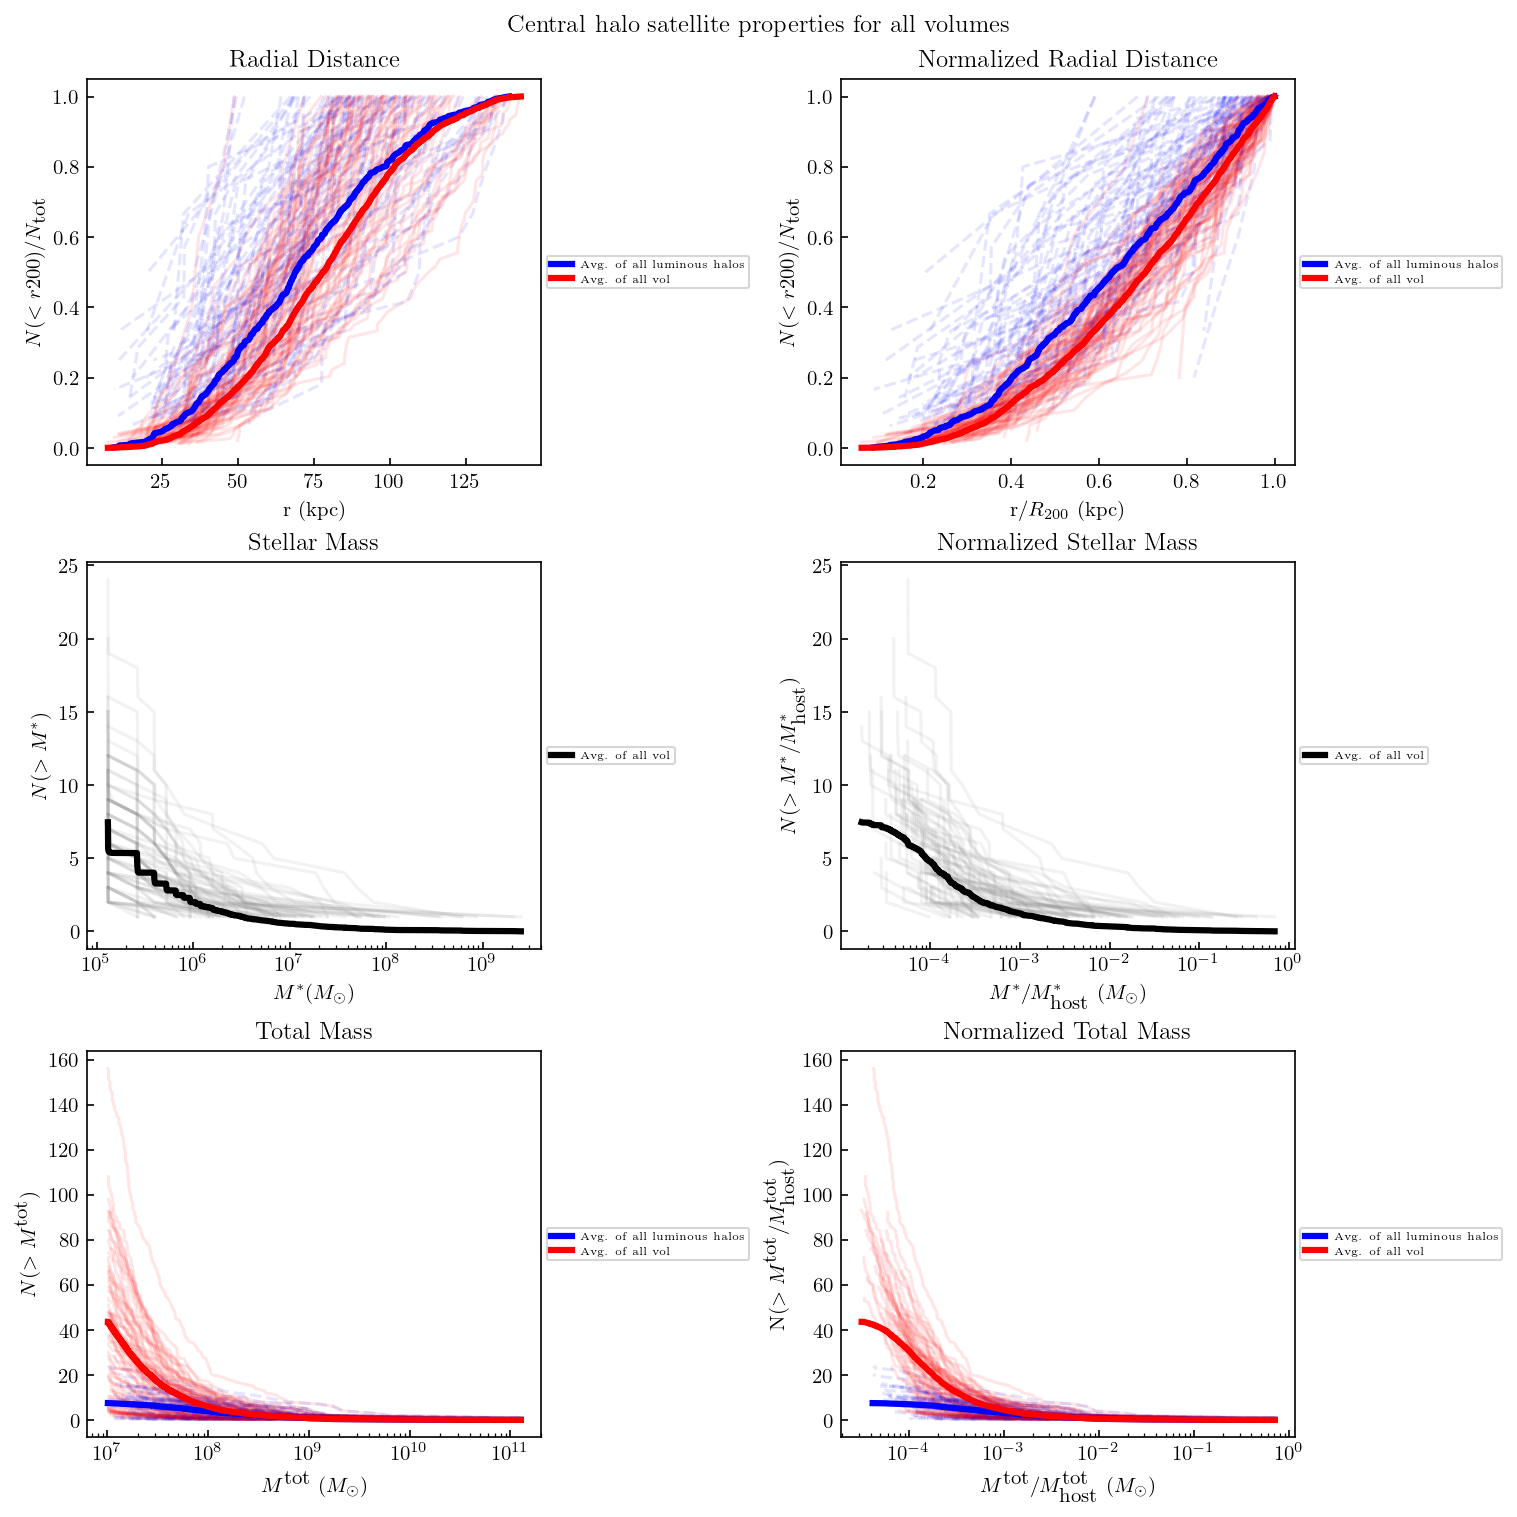

In [100]:
mstar_cut = False
mtot_cut = True
fig, ax = plt.subplots(3, 2, figsize=(10, 10), dpi=150, constrained_layout=True)
ax_flat = ax.flatten()

# Initialize dictionary to store all values
all_array = {
        'Radial Distance': [],
        'Normalized Radial Distance': [],
        'Stellar Mass': [],
        'Normalized Stellar Mass': [],
        'Total Mass': [],
        'Normalized Total Mass': []
    }

volumes = combined_central_df['Volume'].unique()
num_haloes = np.array(combined_central_df.groupby('Volume').count()['Host i'])
vol_cut_start = 0

for vol_idx, vol in enumerate(volumes[vol_cut_start:]):
    arrays = {
        'Radial Distance': [],
        'Normalized Radial Distance': [],
        'Stellar Mass': [],
        'Normalized Stellar Mass': [],
        'Total Mass': [],
        'Normalized Total Mass': []
    }

    central_df = combined_central_df[combined_central_df['Volume'] == vol].copy(deep=True)

    mtot_mask = [np.array(central_df['Sat Mtot'].loc[i]) > 10**7 for i in central_df.index]
    for col in vol15_plotsim.sat_cols:
        for i in range(len(mtot_mask)):
            central_df.at[central_df.index[i], col] = np.array(central_df[col].iloc[i])[mtot_mask[i]]

    for i in central_df.index:
        r200 = central_df['Host R200'].loc[i]
        host_center = np.array(central_df['Host CoM'].loc[i])
        satellite_centers = central_df['Sat CoM'].loc[i]
        distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers]) * 1000

        sat_mstar = central_df['Sat M*'].loc[i]
        sat_mtot = central_df['Sat Mtot'].loc[i]

        arrays['Radial Distance'].append(distances)
        arrays['Normalized Radial Distance'].append(distances / r200)
        arrays['Stellar Mass'].append(sat_mstar)
        arrays['Total Mass'].append(sat_mtot)
        arrays['Normalized Stellar Mass'].append(sat_mstar / central_df['Host M*'].loc[i])
        arrays['Normalized Total Mass'].append(sat_mtot / central_df['Host Mtot'].loc[i])

    non_zero_mask = np.concatenate([np.array(array) != 0 for array in arrays['Stellar Mass']])

    for j, key in enumerate(arrays.keys()):
        if key in ['Radial Distance', 'Normalized Radial Distance']:
            concatenated_array = np.concatenate(arrays[key])

            nonzero_x_values = sorted(concatenated_array[non_zero_mask], reverse=True)
            total_x_values = sorted(concatenated_array, reverse=True)

            nonzero_y_values = np.linspace(len(nonzero_x_values), 1, len(nonzero_x_values)) / len(nonzero_x_values)
            total_y_values = np.linspace(len(total_x_values), 1, len(total_x_values)) / len(total_x_values)

            #ax_flat[j].plot(nonzero_x_values, nonzero_y_values, c=clrs[vol_idx % len(clrs)], label=f'vol. {vol}')
            #ax_flat[j].plot(total_x_values, total_y_values, '--', c=clrs[vol_idx % len(clrs)], alpha=0.3)
            ax_flat[j].set_title(key)
            for i, array in enumerate(arrays[key]):
                try:
                    lum_x_values = sorted(array[arrays['Stellar Mass'][i] != 0], reverse=True)
                    lum_y_values = np.linspace(len(lum_x_values), 1, len(lum_x_values))/len(lum_x_values)
                    x_values = sorted(array, reverse=True)
                    y_values = np.linspace(len(x_values), 1, len(x_values))/len(x_values)
                except TypeError:
                    x_values = []
                    y_values = []
                    lum_x_values = []
                    lum_y_values = []
                ax_flat[j].plot(x_values, y_values, alpha=0.1, c='r')
                ax_flat[j].plot(lum_x_values, lum_y_values, '--', alpha=0.1, c='b')

        elif key in ['Total Mass', 'Normalized Total Mass']:
            concatenated_array = np.concatenate(arrays[key])

            nonzero_x_values = sorted(concatenated_array[non_zero_mask], reverse=True)
            total_x_values = sorted(concatenated_array, reverse=True)

            nonzero_y_values = np.arange(1, len(nonzero_x_values) + 1) / len(central_df)
            total_y_values = np.arange(1, len(total_x_values) + 1) / len(central_df)
            ax_flat[j].set_title(key)
            
            for i, array in enumerate(arrays[key]):
                try:
                    x_values = sorted(array, reverse=True)
                    y_values = np.arange(1, len(x_values) + 1)/num_haloes[i]
                    lum_x_values = sorted(array[arrays['Stellar Mass'][i] != 0], reverse=True)
                    lum_y_values = np.arange(1, len(lum_x_values) + 1)/num_haloes[i]
                except TypeError:
                    x_values = []
                    y_values = []                
                    lum_x_values = []
                    lum_y_values = []
                ax_flat[j].plot(x_values, y_values, alpha=0.1, c='r')
                ax_flat[j].plot(lum_x_values, lum_y_values, '--', alpha=0.1, c='b')

        else:
            mstar_cut_mask = np.concatenate([np.array(array) > 1e5 for array in arrays['Stellar Mass']])
            mstar_concatenated = np.concatenate(arrays[key])[mstar_cut_mask]
            x_values_conc = sorted(mstar_concatenated, reverse=True)
            ax_flat[j].set_xscale('log')
            y_values_conc = np.arange(1, len(x_values_conc) + 1) / len(central_df)
            ax_flat[j].set_title(key)
            for i, array in enumerate(arrays[key]):
                x_values = sorted(array[arrays['Stellar Mass'][i]>1e5], reverse=True)
                y_values = np.arange(1, len(x_values) + 1)
                ax_flat[j].plot(x_values, y_values, alpha=0.1, c='gray')

        all_array[key].append(arrays[key])

for k, key in enumerate(all_array.keys()):
    non_zero_mask = np.concatenate([item for sublist in all_array['Stellar Mass'] for item in sublist]) !=0
    if key in ['Radial Distance', 'Normalized Radial Distance']:
        combined_values = np.concatenate([item for sublist in all_array[key] for item in sublist])
        x_values = sorted(combined_values, reverse=True)
        y_values = np.linspace(len(x_values), 1, len(x_values)) / len(x_values)
        luminous_x_values = sorted(combined_values[non_zero_mask], reverse=True)
        luminous_y_values = np.linspace(len(luminous_x_values), 1, len(luminous_x_values)) / len(luminous_x_values)
        ax_flat[k].plot(luminous_x_values, luminous_y_values, lw=3, c='b', label='Avg. of all luminous halos')
        ax_flat[k].plot(x_values, y_values, lw=3, c='r', label='Avg. of all vol')
    elif key in ['Total Mass', 'Normalized Total Mass']:
        combined_values = np.concatenate([item for sublist in all_array[key] for item in sublist])
        x_values = sorted(combined_values, reverse=True)
        y_values = np.arange(1, len(x_values) + 1) / np.sum(num_haloes[vol_cut_start:])
        luminous_x_values = sorted(combined_values[non_zero_mask])
        luminous_y_values = np.linspace(len(luminous_x_values), 1, len(luminous_x_values)) / np.sum(num_haloes[vol_cut_start:])
        ax_flat[k].plot(luminous_x_values, luminous_y_values, lw=3, c='b', label='Avg. of all luminous halos')
        ax_flat[k].plot(x_values, y_values, lw=3, c='r', label='Avg. of all vol')
    elif key in ['Stellar Mass', 'Normalized Stellar Mass']:
        combined_values = np.concatenate([item for sublist in all_array[key] for item in sublist])
        mstar_cut_mask = np.concatenate([item for sublist in all_array['Stellar Mass'] for item in sublist]) > 1e5
        combined_values = combined_values[mstar_cut_mask]
        x_values = sorted(combined_values, reverse=True)
        y_values = np.arange(1, len(x_values) + 1) / np.sum(num_haloes[vol_cut_start:])
        ax_flat[k].plot(x_values, y_values, lw=3, c='black', label='Avg. of all vol')
    
    ax_flat[k].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=5)

ax_flat[0].set_xlabel('r (kpc)')
ax_flat[0].set_ylabel(r'$N(<r200)/N_{\textrm{tot}}$')

ax_flat[1].set_xlabel(r'r/$R_{200}$ (kpc)')
ax_flat[1].set_ylabel(r'$N(<r200)/N_{\textrm{tot}}$')

ax_flat[2].set_xlabel(r'$M^{*} (M_\odot$)')
ax_flat[2].set_ylabel(r'$N(>M^{*})$')
#ax_flat[2].set_yscale('log')

ax_flat[3].set_xlabel(r'$M^{*}/M^{*}_{\textrm{host}}$ ($M_{\odot}$)')
ax_flat[3].set_ylabel(r'$N(>M^{*}/M^{*}_{\textrm{host}})$')
#ax_flat[3].set_yscale('log')

ax_flat[4].set_xlabel(r'$M^{\textrm{tot}}$ ($M_{\odot}$)')
ax_flat[4].set_ylabel(r'$N(>M^{\textrm{tot}})$')
ax_flat[4].set_xscale('log')

ax_flat[5].set_xlabel(r'$M^\textrm{tot}/M^{\textrm{tot}}_{\textrm{host}}$ ($M_{\odot}$)')
ax_flat[5].set_ylabel(r'N($>M^\textrm{tot}/M^{\textrm{tot}}_{\textrm{host}}$)')
ax_flat[5].set_xscale('log')

fig.suptitle('Central halo satellite properties for all volumes')
plt.show()

#! What is the radius that comntains half od the satellites? (quote in paper)
#! Talk about how many luminous satellites there are on average, and ratio of non-luminous satellites to lum.Useful numbers to quote (population analysis) 

ratio of non-luminous to luminous satellites
- Have to find bin centers and bin the arrays. Tells you ratio at various Host mass

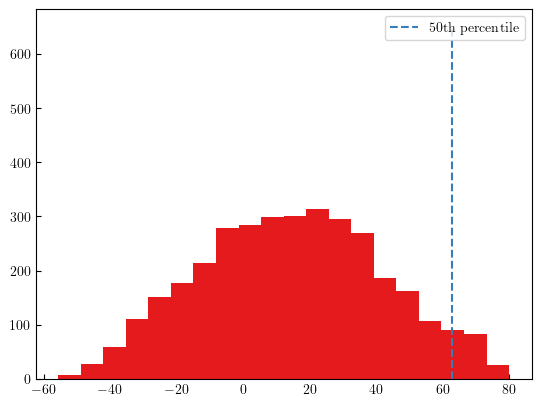

In [63]:
#Histogram of how far the radii are from where 50% of the satellites are
distances_array = np.concatenate([item for sublist in all_array['Radial Distance'] for item in sublist])
r50 = np.quantile(distances, 0.5)
plt.hist(distances_array-r50, bins=20)
plt.vlines(r50, 0, 650, clrs[1], '--', label='50th percentile')
plt.legend()
plt.show()

In [64]:
#ratio of luminous and non-luminous mtotals
non_zero_mask = np.concatenate([item for sublist in all_array['Stellar Mass'] for item in sublist]) !=0
combined_values = np.concatenate([item for sublist in all_array['Total Mass'] for item in sublist])
x_values = sorted(combined_values, reverse=True)
#y_values = np.arange(1, len(x_values) + 1) / np.sum(num_haloes[vol_cut_start:])
luminous_x_values = sorted(combined_values[non_zero_mask])
#luminous_y_values = np.linspace(len(luminous_x_values), 1, len(luminous_x_values)) / np.sum(num_haloes[vol_cut_start:])

print(np.histogram_bin_edges(x_values))
print(len(x_values), len(luminous_x_values))

[1.01154260e+07 1.27431747e+10 2.54762339e+10 3.82092932e+10
 5.09423524e+10 6.36754116e+10 7.64084709e+10 8.91415301e+10
 1.01874589e+11 1.14607649e+11 1.27340708e+11]
3439 589


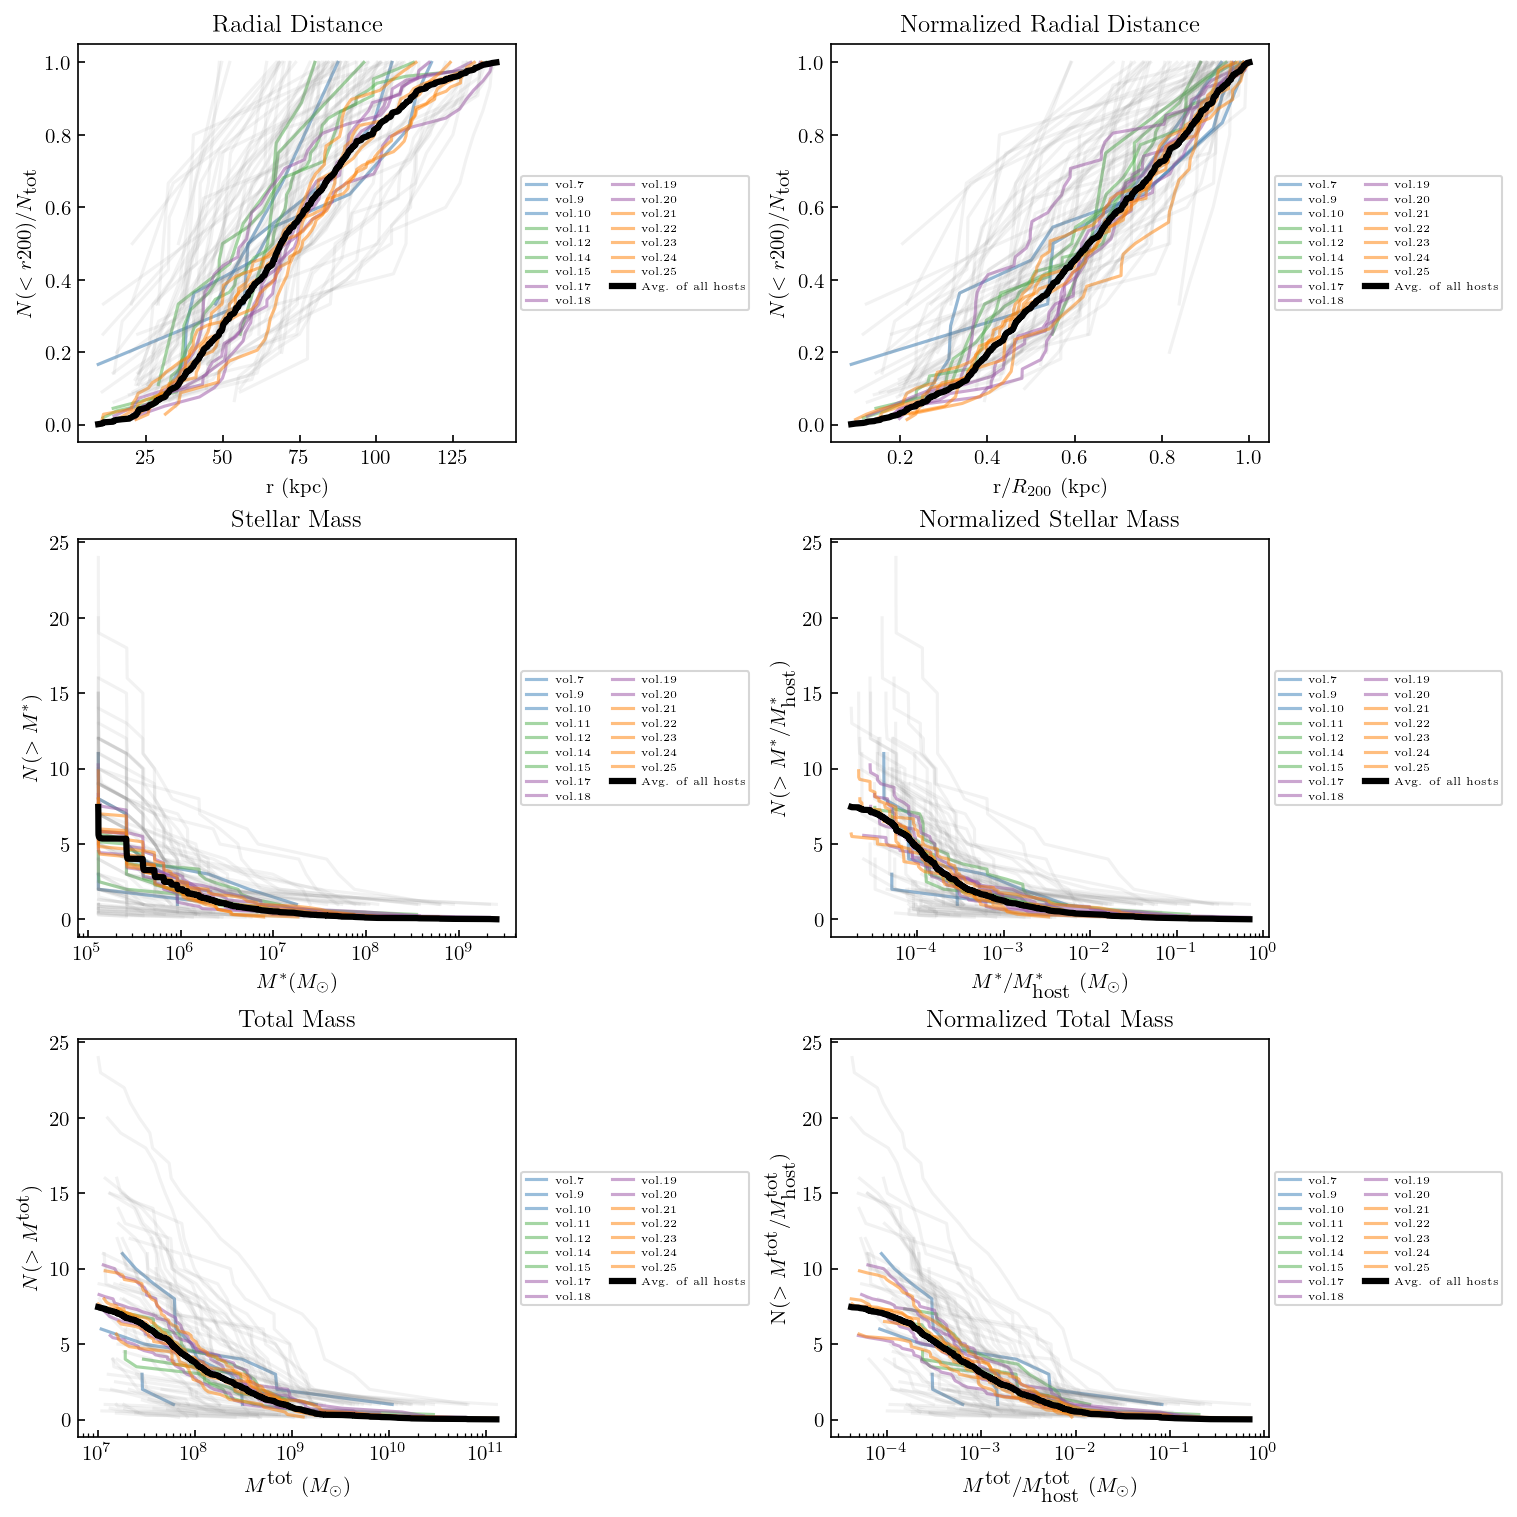

In [119]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 2, figsize=(10, 10), dpi=150, constrained_layout=True)
ax_flat = ax.flatten()
volumes = combined_central_df['Volume'].unique()
all_array = {
    'Radial Distance': [],
    'Normalized Radial Distance': [],
    'Stellar Mass': [],
    'Normalized Stellar Mass': [],
    'Total Mass': [],
    'Normalized Total Mass': []
}
num_haloes = np.array(combined_central_df.groupby('Volume').count()['Host i'])

for vol in volumes:
    arrays = {
        'Radial Distance': [],
        'Normalized Radial Distance': [],
        'Stellar Mass': [],
        'Normalized Stellar Mass': [],
        'Total Mass': [],
        'Normalized Total Mass': []
    }

    central_df = combined_central_df[combined_central_df['Volume'] == vol].copy(deep=True)

    mtot_mask = [np.array(central_df['Sat Mtot'].loc[i]) > 10**7 for i in central_df.index]
    mstar_mask = [np.array(central_df['Sat M*'].loc[i]) > 1e5 for i in central_df.index]
    for col in vol15_plotsim.sat_cols:
        for i in range(len(mtot_mask)):
            filtered_data = np.array(central_df[col].iloc[i])[mtot_mask[i] & mstar_mask[i]]
            central_df.at[central_df.index[i], col] = list(filtered_data)

    for i in central_df.index:
        r200 = central_df['Host R200'].loc[i]
        host_center = np.array(central_df['Host CoM'].loc[i])
        satellite_centers = central_df['Sat CoM'].loc[i]
        distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers]) * 1000

        sat_mstar = central_df['Sat M*'].loc[i]
        sat_mtot = central_df['Sat Mtot'].loc[i]

        arrays['Radial Distance'].append(distances)
        arrays['Normalized Radial Distance'].append(distances / r200)
        arrays['Stellar Mass'].append(sat_mstar)
        arrays['Total Mass'].append(sat_mtot)
        arrays['Normalized Stellar Mass'].append(sat_mstar / central_df['Host M*'].loc[i])
        arrays['Normalized Total Mass'].append(sat_mtot / central_df['Host Mtot'].loc[i])

    # Loop over the first 6 keys in the arrays dictionary
    for j, key in enumerate(list(arrays.keys())):
        all_array[key].extend(arrays[key])
        non_empty_arrays = [arr for arr in arrays[key] if len(arr) > 0]
        if non_empty_arrays:  # Ensure there are non-empty arrays to process
            conc = list(non_empty_arrays[0])
            for arr in non_empty_arrays[1:]:
                conc.extend(arr)

            x_values = sorted(conc, reverse=True)
            if key == 'Radial Distance' or key == 'Normalized Radial Distance':
                y_values = np.linspace(len(x_values), 1, len(x_values)) / len(x_values)
                for i, array in enumerate(arrays[key]):
                    try:
                        halo_x_values = sorted(array, reverse=True)
                        halo_y_values = np.linspace(len(halo_x_values), 1, len(halo_x_values))/len(halo_x_values)
                    except TypeError:
                        halo_x_values = []
                        halo_y_values = []
                    ax_flat[j].plot(halo_x_values, halo_y_values, alpha=0.1, c='gray')
            else:
                ax_flat[j].set_xscale('log')
                y_values = np.arange(1, len(x_values) + 1) / len(central_df)
                for i, array in enumerate(arrays[key]):
                    try:
                        halo_x_values = sorted(array, reverse=True)
                        halo_y_values = np.arange(1, len(halo_x_values) + 1) / num_haloes[i]
                    except TypeError:
                        halo_x_values = []
                        halo_y_values = []
                    ax_flat[j].plot(halo_x_values, halo_y_values, alpha=0.1, c='gray')

            # Plot the values with a label for the host index
            ax_flat[j].plot(x_values, y_values, '-', c = clrs[int((vol-1)/5)], label=f'vol.{vol}', alpha = 0.5)
            ax_flat[j].set_title(key)
            ax_flat[j].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fontsize=5)

for k, key in enumerate(all_array.keys()):
    non_empty_allarrays = [arr for sublist in all_array[key] for arr in sublist if arr.any()]
    combined_values = sorted(non_empty_allarrays, reverse=True)
    if key in ['Radial Distance', 'Normalized Radial Distance']:
        y_values = np.linspace(len(combined_values), 1, len(combined_values)) / len(combined_values)
    else:
        y_values = np.arange(1, len(combined_values) + 1) / np.sum(num_haloes)

    ax_flat[k].plot(combined_values, y_values, lw=3, c='black', label='Avg. of all hosts')
    ax_flat[k].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fontsize=5)

# Set axis labels
ax_flat[0].set_xlabel('r (kpc)')
ax_flat[0].set_ylabel(r'$N(<r200)/N_{\textrm{tot}}$')

ax_flat[1].set_xlabel(r'r/$R_{200}$ (kpc)')
ax_flat[1].set_ylabel(r'$N(<r200)/N_{\textrm{tot}}$')

ax_flat[2].set_xlabel(r'$M^{*} (M_\odot$)')
ax_flat[2].set_ylabel(r'$N(>M^{*})$')
#ax_flat[2].set_yscale('log')

ax_flat[3].set_xlabel(r'$M^{*}/M^{*}_{\textrm{host}}$ ($M_{\odot}$)')
ax_flat[3].set_ylabel(r'$N(>M^{*}/M^{*}_{\textrm{host}})$')
#ax_flat[3].set_yscale('log')

ax_flat[4].set_xlabel(r'$M^{\textrm{tot}}$ ($M_{\odot}$)')
ax_flat[4].set_ylabel(r'$N(>M^{\textrm{tot}})$')
#ax_flat[4].set_yscale('log')

ax_flat[5].set_xlabel(r'$M^\textrm{tot}/M^{\textrm{tot}}_{\textrm{host}}$ ($M_{\odot}$)')
ax_flat[5].set_ylabel(r'N($>M^\textrm{tot}/M^{\textrm{tot}}_{\textrm{host}}$)')
#ax_flat[5].set_yscale('log')

plt.show()

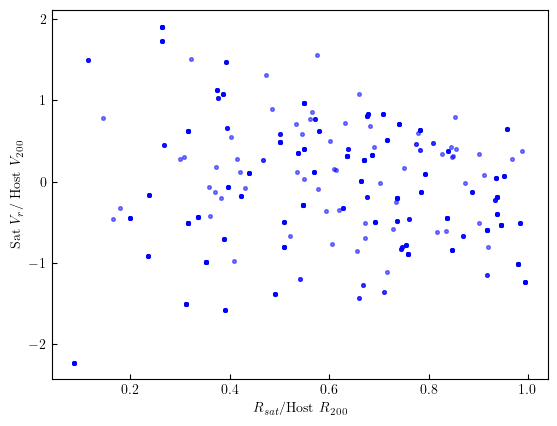

In [102]:
import matplotlib.pyplot as plt
import numpy as np

for i in combined_central_df['Host i']:
    lum_mask = np.array(combined_central_df['Sat M*'].loc[i]) != 0
    host_center = np.array(combined_central_df['Host CoM'].loc[i])
    satellite_centers = np.array(combined_central_df['Sat CoM'].loc[i])[lum_mask]  # Correct initialization here
    distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers]) * 1000  # kpc
    dist_vector = (np.array(satellite_centers) - host_center)
    dist_vector_norm = [r * 1000 / dist for r, dist in zip(dist_vector, distances)]  # kpc for r*1000 ##fine
    relative_v = np.subtract(np.array(combined_central_df['Sat CoMV'].loc[i])[lum_mask], combined_central_df['Host CoMV'].loc[i])
    sat_Vr = [np.dot(v, d) for v, d in zip(dist_vector_norm, relative_v)]
    host_V200 = combined_central_df['Host R200'].loc[i] * 0.681
    
    plt.scatter(distances / combined_central_df['Host R200'].loc[i], (sat_Vr) / host_V200, label=f'Satellites of Host {i+1}', s=7, alpha=0.5, c='b')
    #plt.scatter(distances, sat_Vr, label=f'Satellites of Host {i+1}', s=7, alpha=0.5, c='b')
    
    dist = np.linspace(0.1, 1, 100)
    G = 4.3e-6  # kpc
    esc_v = np.sqrt(2 * G * combined_central_df['Host Mtot'].loc[i] / (dist * combined_central_df['Host R200'].loc[i])) / host_V200
    
    #plt.plot(dist, esc_v, 'Black')
    #plt.plot(dist, -esc_v, 'Black')
    #plt.ylim(-20, 20)

plt.xlabel(r'$R_{sat}$/Host $R_{200}$')
plt.ylabel(r'Sat $V_r$/ Host $V_{200}$')
#plt.legend()
plt.show()
